<div style="background-color:lightyellow; padding:10px; border-radius:5px; border:1px solid black;">
    <h1 style="color:darkblue; text-align:center;">Used Vehicle Prices</h1>
    <h3 style="color:gray; text-align:center;">A Comprehensive Exploratory Data Analysis</h3>
</div>

# **Import Modules**

---

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from scipy import stats

from sklearn import set_config

set_config(display="diagram") 
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# **Import Data**
## _Upload dataset and take a quick look_

---

In [5]:
used_vehicle_data = pd.read_csv('data/vehicles.csv')
orig_df = used_vehicle_data.copy()
used_vehicle_data.set_index('id', inplace = True) #set id as index

In [6]:
used_vehicle_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 426880 entries, 7222695916 to 7301591129
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        426880 non-null  object 
 1   price         426880 non-null  int64  
 2   year          425675 non-null  float64
 3   manufacturer  409234 non-null  object 
 4   model         421603 non-null  object 
 5   condition     252776 non-null  object 
 6   cylinders     249202 non-null  object 
 7   fuel          423867 non-null  object 
 8   odometer      422480 non-null  float64
 9   title_status  418638 non-null  object 
 10  transmission  424324 non-null  object 
 11  VIN           265838 non-null  object 
 12  drive         296313 non-null  object 
 13  size          120519 non-null  object 
 14  type          334022 non-null  object 
 15  paint_color   296677 non-null  object 
 16  state         426880 non-null  object 
dtypes: float64(2), int64(1), object(14)
memo

Taking a look at the data. We can see that we have three numeric columns (one int and two float) and 14 categorical columns (this is excluding id which we have set as the index since these are unique values). The three numeric columns are: `price` (our response variable), `year`, and `odometer`. The object or categorical columns are: `region`, `manufacturer`, `model`, `condition`, `cylinders`, `fuel`, `title_status`, `transmission`, `VIN`, `drive`, `size`, `type`, `paint_color`, and `state`.

As we explore the dataset, some of these categorical variables very likely could be recoded as numeric variables or could be ordinally encoded.

Lastly, the column names look clean and in snake case. VIN will be removed since it is uninformative of price, so even though it is not all lowercase, we will not be using it past cleaning.

In [8]:
used_vehicle_data.shape

(426880, 17)

There are currently 426,880 rows with 17 columns (14 categorical and 3 numeric)

In [10]:
used_vehicle_data.sample(10)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
id,,,,,,,,,,,,,,,,,
7314800179,las vegas,19556,2019.0,buick,encore,NaN,4 cylinders,gas,35303.0,clean,automatic,NaN,fwd,compact,SUV,white,nv
7307759040,olympic peninsula,49999,2016.0,jeep,grand cherokee,NaN,8 cylinders,gas,52272.0,clean,automatic,1C4RJFDJ2GC446184,4wd,NaN,SUV,custom,wa
7312953642,macon / warner robins,43499,2020.0,chevrolet,silverado 1500 lt,NaN,NaN,gas,28710.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,ga
7312185248,anchorage / mat-su,3500,2001.0,ford,ranger,NaN,NaN,gas,161000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,ak
7316228047,bozeman,39998,2020.0,toyota,rav4 hybrid xse,NaN,4 cylinders,hybrid,14134.0,clean,automatic,JTMEWRFV2LJ037139,4wd,NaN,SUV,NaN,mt
7303091702,waco,25995,2015.0,toyota,tacoma,NaN,NaN,gas,120355.0,clean,automatic,5TFLU4EN9FX112972,4wd,NaN,truck,NaN,tx
7316025072,panama city,18900,1981.0,chevrolet,corvette,excellent,8 cylinders,gas,65400.0,clean,manual,NaN,rwd,NaN,coupe,silver,fl
7314423544,hawaii,10446,2012.0,gmc,terrain,NaN,4 cylinders,gas,105414.0,clean,automatic,2GKALMEK6C6298440,fwd,NaN,SUV,white,hi
7310971765,cleveland,6500,2008.0,mazda,cx-9,excellent,NaN,gas,180000.0,clean,automatic,NaN,4wd,full-size,SUV,blue,oh


Here we take a brief peek at the data and see that there are missing values coded as NaN in a number of the columns.

# **Clean Data**
## _Check for duplicates, check missing values to see if imputation is needed, remove any rows and variables that are uninformative or out of context for our used car dealership_

---

### Check for duplicates

In [14]:
sum(orig_df.duplicated()) #We use the orig_df because we are now using ID as the index, we want to keep all unique cases

0

There are no duplicated cells. So, we can move on to exploring the missing values, but first let's go ahead and drop `VIN`. 

This alphanumeric is used to identify that specific vehicle and does not offer any connection to price (i.e., it is a unique identifier). Further, if we were to use `VIN`, the vast number of unique VIN numbers would result in way too many columns after one-hot encoding. Finally, even though there are a number of duplicated `VIN` values, I am treating this is a sample with replacement of the original 3 million plus row dataset. This would explain the duplicated rows when excluding `id`. Since, `id` is unique to each row, I will treat each row as a case in an experiment.

In [16]:
used_vehicle_data.drop(columns = 'VIN', inplace = True)

### Check Missing Values

In [18]:
used_vehicle_data.isna().mean().round(4)*100

region           0.00
price            0.00
year             0.28
manufacturer     4.13
model            1.24
condition       40.79
cylinders       41.62
fuel             0.71
odometer         1.03
title_status     1.93
transmission     0.60
drive           30.59
size            71.77
type            21.75
paint_color     30.50
state            0.00
dtype: float64

As we can see, there are 6 columns with greater than 20% missing data: `condition`, `cylinders`, `drive`, `size`, `type`, and `paint_color`. These columns will likely need to be imputed, or dropped if deemed not important to the model. There are 7 columns with 4.5% - 0.28% missing data: `year`, `manufacturer`, `model`, `fuel`, `odometer`, `title_status`, and `transmission`. These are good candidates for imputation.

### Check Categorical Variables

In [21]:
used_vehicle_data.select_dtypes('object').columns

Index(['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color',
       'state'],
      dtype='object')

#### `region`

In [23]:
used_vehicle_data['region'].value_counts()

region
columbus                   3608
jacksonville               3562
spokane / coeur d'alene    2988
eugene                     2985
fresno / madera            2983
                           ... 
meridian                     28
southwest MS                 14
kansas city                  11
fort smith, AR                9
west virginia (old)           8
Name: count, Length: 404, dtype: int64

In [24]:
len(used_vehicle_data['region'].value_counts()) #Check how many distinct values are in `region`

404

There are large number of categories for `region` (i.e., too many too one-hot encode). This would also not make the most practical sense to include, because we have `state`. Which as we will see has fewer categories

#### `manufacturer`

In [27]:
used_vehicle_data['manufacturer'].value_counts()

manufacturer
ford               70985
chevrolet          55064
toyota             34202
honda              21269
nissan             19067
jeep               19014
ram                18342
gmc                16785
bmw                14699
dodge              13707
mercedes-benz      11817
hyundai            10338
subaru              9495
volkswagen          9345
kia                 8457
lexus               8200
audi                7573
cadillac            6953
chrysler            6031
acura               5978
buick               5501
mazda               5427
infiniti            4802
lincoln             4220
volvo               3374
mitsubishi          3292
mini                2376
pontiac             2288
rover               2113
jaguar              1946
porsche             1384
mercury             1184
saturn              1090
alfa-romeo           897
tesla                868
fiat                 792
harley-davidson      153
ferrari               95
datsun                63
aston-martin

In [28]:
len(used_vehicle_data['manufacturer'].value_counts()) #Check how many distinct values are in `manufacturer`

42

There are a lot of regions here. While there are not as many levels to `region` as `model`, adding 42 different one-hot encoded columns could get messy. One way to recode this would be by the geographical continent/region. We will do this below and reduce this column from 42 levels to 3 levels. 

In [30]:
# Mapping of manufacturers to regions
region_mapping = {
    'ford': 'North America',
    'chevrolet': 'North America',
    'toyota': 'Asia',
    'honda': 'Asia',
    'nissan': 'Asia',
    'jeep': 'North America',
    'ram': 'North America',
    'gmc': 'North America',
    'bmw': 'Europe',
    'dodge': 'North America',
    'mercedes-benz': 'Europe',
    'hyundai': 'Asia',
    'subaru': 'Asia',
    'volkswagen': 'Europe',
    'kia': 'Asia',
    'lexus': 'Asia',
    'audi': 'Europe',
    'cadillac': 'North America',
    'chrysler': 'North America',
    'acura': 'Asia',
    'buick': 'North America',
    'mazda': 'Asia',
    'infiniti': 'Asia',
    'lincoln': 'North America',
    'volvo': 'Europe',
    'mitsubishi': 'Asia',
    'mini': 'Europe',
    'pontiac': 'North America',
    'rover': 'Europe',
    'jaguar': 'Europe',
    'porsche': 'Europe',
    'mercury': 'North America',
    'saturn': 'North America',
    'alfa-romeo': 'Europe',
    'tesla': 'North America',
    'fiat': 'Europe',
    'harley-davidson': 'North America',
    'ferrari': 'Europe',
    'datsun': 'Asia',
    'aston-martin': 'Europe',
    'land rover': 'Europe',
    'morgan': 'Europe'
}

# Map manufacturers to regions
used_vehicle_data['manufacturer_region'] = used_vehicle_data['manufacturer'].map(region_mapping)

In [31]:
used_vehicle_data['manufacturer_region'].value_counts()

manufacturer_region
North America    222185
Asia             130590
Europe            56459
Name: count, dtype: int64

This looks much better and allows for larger groups to pick up signal.

#### `model`

In [34]:
used_vehicle_data['model'].value_counts()

model
f-150                      8009
silverado 1500             5140
1500                       4211
camry                      3135
silverado                  3023
                           ... 
plymouth fury 1               1
f550 box truck delivery       1
duramax 2500hd                1
3 s sport                     1
Paige Glenbrook Touring       1
Name: count, Length: 29649, dtype: int64

In [35]:
len(used_vehicle_data['model'].value_counts()) #Check how many distinct values are in `model`

29649

Way too many categories for one-hot encoding and the specific name of the type of car is not immediately informative. If there was more time, this would be one way to look up specific cars to find values to fill in the missing values of specific cases. We will likely drop this column.

#### `condition`

In [38]:
used_vehicle_data['condition'].value_counts()

condition
good         121456
excellent    101467
like new      21178
fair           6769
new            1305
salvage         601
Name: count, dtype: int64

`condition` has some nice categories that appear to be "equally distanced." Let's go ahead and explicitly recode this column to an ordinal variable.

In [40]:
# Create a dictionary to map condition values to ordinal scale
condition_mapping = {
    "salvage": 0,
    "fair": 1,
    "good": 2,
    "excellent": 3,
    "like new": 4,
    "new": 5
}

# Apply the mapping to the 'condition' column
used_vehicle_data["condition_ordinal"] = used_vehicle_data["condition"].map(condition_mapping)

In [41]:
used_vehicle_data['condition_ordinal'].describe()

count    252776.000000
mean          2.552928
std           0.716633
min           0.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           5.000000
Name: condition_ordinal, dtype: float64

In [42]:
used_vehicle_data['condition_ordinal'].isna().sum()/used_vehicle_data['condition_ordinal'].shape[0] #percent missing in column

0.40785232383808095

There is still a little over 40% of the data missing, so we will have to decide in the future whether to impute it or drop it.

#### `cylinders`

In [45]:
used_vehicle_data['cylinders'].value_counts()

cylinders
6 cylinders     94169
4 cylinders     77642
8 cylinders     72062
5 cylinders      1712
10 cylinders     1455
other            1298
3 cylinders       655
12 cylinders      209
Name: count, dtype: int64

In [46]:
used_vehicle_data['cylinders'].isna().sum()/used_vehicle_data['cylinders'].shape[0] #percent missing in column

0.416224700149925

Cylinders at first appears to be a good candidate for ordinal encoding. However, in looking at the 'other' category we can find a number of electric vehicles. These cars do not have cylinders. This could introduce multicollinearity with `fuel`. This could cause some issues for linear regression, but won't be as much of a concern with Lasso and Ridge regression. There is still a lot of data missing, so we will have to either drop the column or impute the missing values.

#### `fuel`

In [49]:
used_vehicle_data['fuel'].value_counts()

fuel
gas         356209
other        30728
diesel       30062
hybrid        5170
electric      1698
Name: count, dtype: int64

In [50]:
used_vehicle_data['fuel'].isna().sum()/used_vehicle_data['fuel'].shape[0] #percent missing in column

0.007058189655172414

This is a great candidate for one-hot encoding. We can impute the few missing cases with the most frequent category.

#### `title_status`

In [53]:
used_vehicle_data['title_status'].value_counts()

title_status
clean         405117
rebuilt         7219
salvage         3868
lien            1422
missing          814
parts only       198
Name: count, dtype: int64

In [54]:
used_vehicle_data['title_status'].isna().sum()/used_vehicle_data['title_status'].shape[0] #percent missing in column

0.019307533733133434

This is a great candidate for one-hot encoding. We can impute the few missing cases with the most frequent category.

#### `transmission`

In [57]:
used_vehicle_data['transmission'].value_counts()

transmission
automatic    336524
other         62682
manual        25118
Name: count, dtype: int64

In [58]:
used_vehicle_data['transmission'].isna().sum()/used_vehicle_data['transmission'].shape[0] #percent missing in column

0.0059876311844077965

This is a great candidate for one-hot encoding. We can impute the few missing cases with the most frequent category.

#### `drive`

In [61]:
used_vehicle_data['drive'].value_counts()

drive
4wd    131904
fwd    105517
rwd     58892
Name: count, dtype: int64

In [62]:
used_vehicle_data['drive'].isna().sum()/used_vehicle_data['drive'].shape[0] #percent missing in column

0.30586347451274365

`drive` could potentially be one-hot encoded, but there are still a lot of missing values. We will consider imputing with the mode later.

#### `size`

In [65]:
used_vehicle_data['size'].value_counts()

size
full-size      63465
mid-size       34476
compact        19384
sub-compact     3194
Name: count, dtype: int64

In [66]:
# Create a dictionary to map condition values to ordinal scale
size_mapping = {
    "sub-compact": 0,
    "compact": 1,
    "mid-size": 2,
    "full-size": 3
}

# Apply the mapping to the 'condition' column
used_vehicle_data["size_ordinal"] = used_vehicle_data["size"].map(size_mapping)

In [67]:
used_vehicle_data['size_ordinal'].describe()

count    120519.000000
mean          2.312756
std           0.834046
min           0.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           3.000000
Name: size_ordinal, dtype: float64

In [68]:
used_vehicle_data['size_ordinal'].isna().sum()/used_vehicle_data['size_ordinal'].shape[0] #percent missing in column

0.7176747563718141

Likely too many missing values here, above 70%, so we should probably drop this.

#### `type`

In [71]:
used_vehicle_data['type'].value_counts()

type
sedan          87056
SUV            77284
pickup         43510
truck          35279
other          22110
coupe          19204
hatchback      16598
wagon          10751
van             8548
convertible     7731
mini-van        4825
offroad          609
bus              517
Name: count, dtype: int64

In [72]:
used_vehicle_data['type'].isna().sum()/used_vehicle_data['type'].shape[0] #percent missing in column

0.21752717391304346

We can probably one-hot encode this and impute the missing values with the mode.

#### `paint_color`

In [75]:
used_vehicle_data['paint_color'].value_counts()

paint_color
white     79285
black     62861
silver    42970
blue      31223
red       30473
grey      24416
green      7343
custom     6700
brown      6593
yellow     2142
orange     1984
purple      687
Name: count, dtype: int64

In [76]:
used_vehicle_data['paint_color'].isna().sum()/used_vehicle_data['paint_color'].shape[0] #percent missing in column

0.305010775862069

We can probably one-hot encode `paint_color`. However, 30% missing data is still kind of a little high for my liking.

#### `state`

In [79]:
used_vehicle_data['state'].value_counts()

state
ca    50614
fl    28511
tx    22945
ny    19386
oh    17696
or    17104
mi    16900
nc    15277
wa    13861
pa    13753
wi    11398
co    11088
tn    11066
va    10732
il    10387
nj     9742
id     8961
az     8679
ia     8632
ma     8174
mn     7716
ga     7003
ok     6792
sc     6327
mt     6294
ks     6209
in     5704
ct     5188
al     4955
md     4778
nm     4425
mo     4293
ky     4149
ar     4038
ak     3474
la     3196
nv     3194
nh     2981
dc     2970
me     2966
hi     2964
vt     2513
ri     2320
sd     1302
ut     1150
wv     1052
ne     1036
ms     1016
de      949
wy      610
nd      410
Name: count, dtype: int64

In [80]:
len(used_vehicle_data['state'].value_counts()) #Check how many distinct values are in `state`

51

51 categories converted to one-hot encoded columns would mean introducing 50 more columns. This could likely complicate the analysis and make it difficult to understand what is driving `price`. So, I used the US Census Sub categories for regions in the United States. This allows us to reduce the levels from 51 to 9.

In [82]:
# Mapping of states to regions and divisions
state_region_mapping = {
    "ak": "West Pacific", "al": "South East South Central", "ar": "South West South Central",
    "az": "West Mountain", "ca": "West Pacific", "co": "West Mountain", "ct": "Northeast New England",
    "dc": "South South Atlantic", "de": "South South Atlantic", "fl": "South South Atlantic",
    "ga": "South South Atlantic", "hi": "West Pacific", "ia": "Midwest West North Central",
    "id": "West Mountain", "il": "Midwest East North Central", "in": "Midwest East North Central",
    "ks": "Midwest West North Central", "ky": "South East South Central", "la": "South West South Central",
    "ma": "Northeast New England", "md": "South South Atlantic", "me": "Northeast New England",
    "mi": "Midwest East North Central", "mn": "Midwest West North Central", "mo": "Midwest West North Central",
    "ms": "South East South Central", "mt": "West Mountain", "nc": "South South Atlantic",
    "nd": "Midwest West North Central", "ne": "Midwest West North Central", "nh": "Northeast New England",
    "nj": "Northeast Middle Atlantic", "nm": "West Mountain", "nv": "West Mountain",
    "ny": "Northeast Middle Atlantic", "oh": "Midwest East North Central", "ok": "South West South Central",
    "or": "West Pacific", "pa": "Northeast Middle Atlantic", "ri": "Northeast New England",
    "sc": "South South Atlantic", "sd": "Midwest West North Central", "tn": "South East South Central",
    "tx": "South West South Central", "ut": "West Mountain", "va": "South South Atlantic",
    "vt": "Northeast New England", "wa": "West Pacific", "wi": "Midwest East North Central",
    "wv": "South South Atlantic", "wy": "West Mountain"
}

# Map the regions to the dataframe
used_vehicle_data["state_region"] = used_vehicle_data["state"].map(state_region_mapping)

In [83]:
used_vehicle_data['state_region'].value_counts()

state_region
West Pacific                  88017
South South Atlantic          77599
Midwest East North Central    62085
West Mountain                 44401
Northeast Middle Atlantic     42881
South West South Central      36971
Midwest West North Central    29598
Northeast New England         24142
South East South Central      21186
Name: count, dtype: int64

`model` and `region` can be dropped because there are too many categories for us to utilize. `condition` and `condition_ordinal` are dropped for now since they have over 40% missing data. I am dropping `size` and `size_ordinal`, since `size` has more than 70% of the data missing. I am also dropping `manufacturer` since there are a large number of categories and we have recoded it as `manufacturer_region`. Finally, we can drop `state` since we have recoded it as `state_region`. This was done because we likely do not need that level of granularity, yet where a car is located in the United States can definitely impact the overall condition due to things like salt-usage during winters in the Midwest.

In [85]:
used_vehicle_data = used_vehicle_data.drop(columns = ['model', 'region', 'condition', 'size', 'size_ordinal', 'manufacturer', 'state'])

In [86]:
used_vehicle_data[used_vehicle_data['price'] == 0].shape[0]

32895

In [87]:
data_lost_after_dropping_zero = 1 - (used_vehicle_data[used_vehicle_data['price'] != 0].shape[0]/used_vehicle_data.shape[0])
print("We lost {:.8%} of the data by dropping cars with $0 price".format(data_lost_after_dropping_zero))

We lost 7.70591267% of the data by dropping cars with $0 price


In [88]:
used_vehicle_data = used_vehicle_data[used_vehicle_data['price'] > 0].copy()

After thinking long and hard about whether or not to filter the dataset for vehicles that have a price of greater than 0 dollars, I decided that yes, these values should be exlcuded given the context of our problem. We are tasked with determining what factors drive the price of a vehicle for a used car dealership. Cars are not sold for 0 dollars at a dealership. When used cars are sold for 0 dollars this is usually a person gifting a person another car or other extraneous circumstances, and would skew the data toward the lower values. For these reasons, we filter the data for values greater than 0 in the `price` column.

Our final columns to start EDA are as follows:

In [91]:
used_vehicle_data.columns

Index(['price', 'year', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'drive', 'type', 'paint_color', 'manufacturer_region',
       'condition_ordinal', 'state_region'],
      dtype='object')

We are left with our response variable, `price`, and our explanatory variables: `year`, `cylinders`, `fuel`, `odometer`, `title_status`, `transmission`, `drive`, `type`, `paint_color`, `manufacturer_region`, `condtion_ordinal`, and `state_region`.

# **Exploratory Data Analysis (EDA)**
## _Examine univariate and multivariate analysis of variables_

---

### Univariate Analysis of Target Variable: `price`

In [95]:
pd.set_option('display.float_format', lambda x: '%.2f'% x)

In [96]:
used_vehicle_data[['price']].describe()

,price
count,393985.00
mean,81477.63
std,12680636.89
min,1.00
25%,7000.00
50%,15000.00
75%,27590.00
max,3736928711.00


In [97]:
p = [0.05, 0.85, 0.95, 0.99]
used_vehicle_data[['price']].describe(p)

,price
count,393985.00
mean,81477.63
std,12680636.89
min,1.00
5%,1988.00
50%,15000.00
85%,33995.00
95%,44999.00
99%,68747.48
max,3736928711.00


Looks like our data is very rightly skewed with a number of extreme outliers including one car that sold for $3,736,928,711.00

<Axes: title={'center': 'Boxplot of `price`'}>

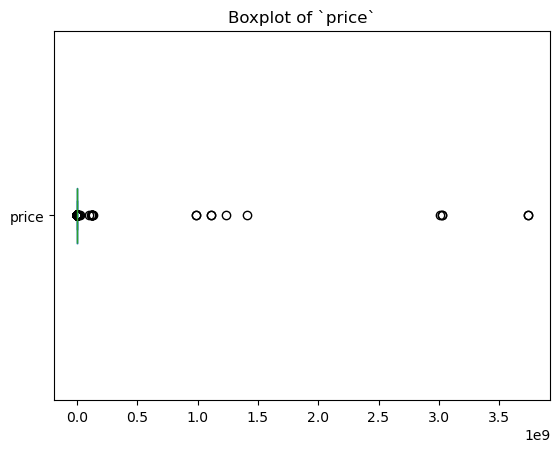

In [99]:
used_vehicle_data['price'].plot(kind = 'box', vert = False, title = "Boxplot of `price`")

Our data is highly rightly skewed due to some very expensive cars in the dataset. One way to combat this is by conducting a log or square root transformation on the `price` variable. I have only included a box plot here, because the other graphs are uninformative due to skewness.

#### Apply log and sqrt transformations

In [102]:
used_vehicle_data['price_log'] = np.log(used_vehicle_data['price'])
used_vehicle_data['price_sqrt'] = np.sqrt(used_vehicle_data['price'])
used_vehicle_data.sample(10)

,price,year,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,manufacturer_region,condition_ordinal,state_region,price_log,price_sqrt
id,,,,,,,,,,,,,,,
7308132587,4999,2004.00,6 cylinders,gas,141000.00,clean,automatic,4wd,SUV,NaN,North America,3.00,Midwest West North Central,8.52,70.70
7311890352,21000,1979.00,8 cylinders,gas,33928.00,clean,automatic,rwd,coupe,black,North America,3.00,West Mountain,9.95,144.91
7303017201,9995,1994.00,8 cylinders,gas,97237.00,clean,automatic,rwd,NaN,blue,North America,NaN,Northeast New England,9.21,99.97
7316199255,2900,2000.00,4 cylinders,gas,231000.00,clean,automatic,fwd,NaN,black,Asia,2.00,Midwest East North Central,7.97,53.85
7310547359,4250,2005.00,4 cylinders,gas,267000.00,clean,automatic,fwd,sedan,NaN,Asia,NaN,South South Atlantic,8.35,65.19
7313877606,26990,2017.00,NaN,gas,41147.00,clean,other,NaN,sedan,red,North America,2.00,Midwest East North Central,10.20,164.29
7310994808,13995,2010.00,NaN,gas,25744.00,clean,automatic,NaN,NaN,NaN,Asia,NaN,Northeast Middle Atlantic,9.55,118.30
7311410935,42995,2018.00,8 cylinders,gas,71423.00,clean,automatic,4wd,NaN,NaN,North America,3.00,Midwest East North Central,10.67,207.35
7317027150,11999,2011.00,6 cylinders,gas,82508.00,clean,automatic,fwd,SUV,silver,North America,3.00,West Pacific,9.39,109.54


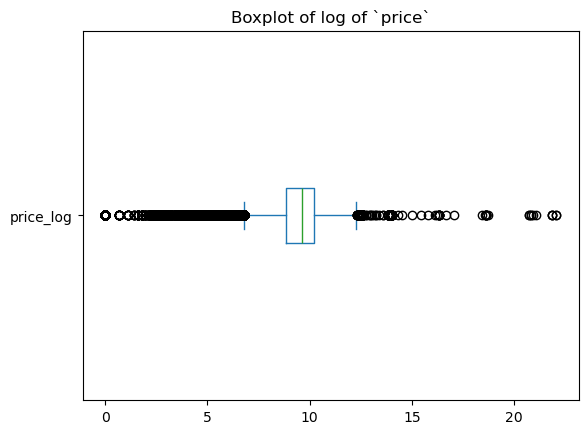

In [103]:
used_vehicle_data['price_log'].plot(kind = 'box', vert = False, title = "Boxplot of log of `price`");

This looks much better, but I think it makes the most sense to remove outliers and then take another look at `price`, `price_log`, and `price_sqrt`.

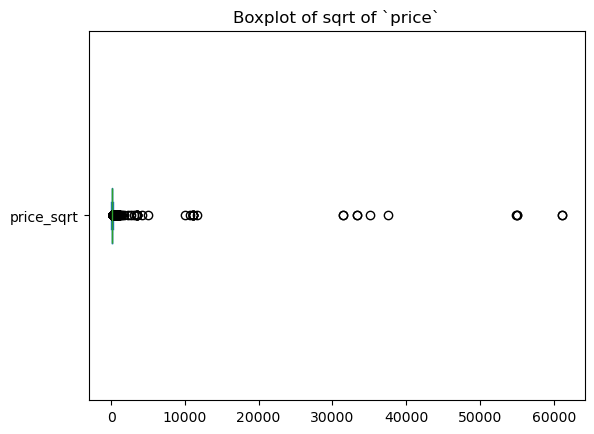

In [105]:
used_vehicle_data['price_sqrt'].plot(kind = 'box', vert = False, title = "Boxplot of sqrt of `price`");

Since there are such extreme outliers right now, the square root transformation is not as effective. It may be better after removing the outliers.

### Outlier Treatment

#### z-score Method

In [109]:
used_vehicle_data_zscore = used_vehicle_data[np.abs(stats.zscore(used_vehicle_data['price'])) < 3].copy() # Remove those rows where ther price is more than 3 z-scores away from the mean
print(used_vehicle_data_zscore.shape, used_vehicle_data.shape)

(393965, 15) (393985, 15)


In [110]:
zscore_data_lost = 1 - (used_vehicle_data_zscore.shape[0]/used_vehicle_data.shape[0])
print("We lost {:.8%} of the data by the z-score method".format(zscore_data_lost))

We lost 0.00507634% of the data by the z-score method


In [111]:
used_vehicle_data_zscore['price'].describe()

count     393965.00
mean       19383.20
std        75856.18
min            1.00
25%         7000.00
50%        15000.00
75%        27590.00
max     25003000.00
Name: price, dtype: float64

<Axes: title={'center': 'Boxplot of `price` after z-score method for outlier removal'}>

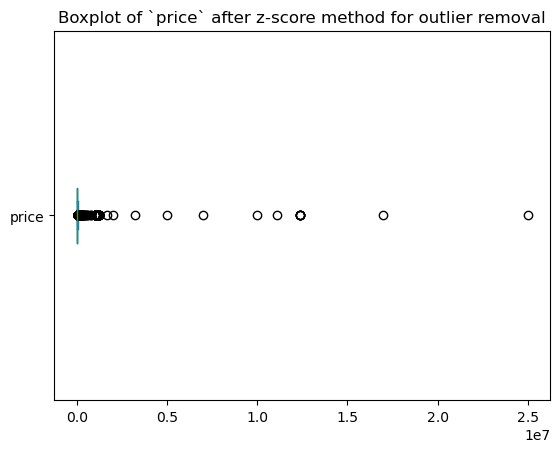

In [112]:
used_vehicle_data_zscore['price'].plot(kind = 'box', vert = False, title = 'Boxplot of `price` after z-score method for outlier removal')

<Axes: title={'center': 'Boxplot of `price_log` after z-score method for outlier removal'}>

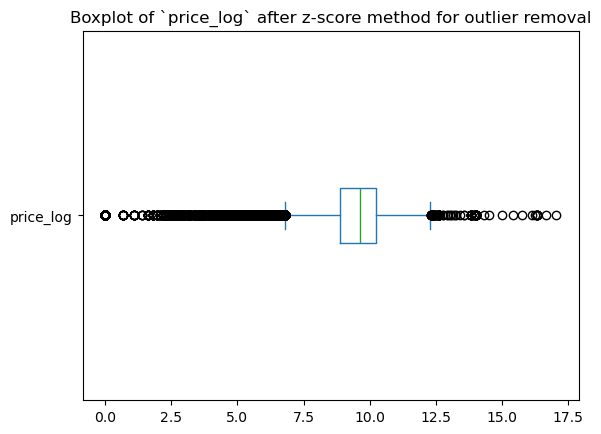

In [113]:
used_vehicle_data_zscore['price_log'].plot(kind = 'box', vert = False, title = 'Boxplot of `price_log` after z-score method for outlier removal')

<Axes: title={'center': 'Boxplot of `price_sqrt` after z-score method for outlier removal'}>

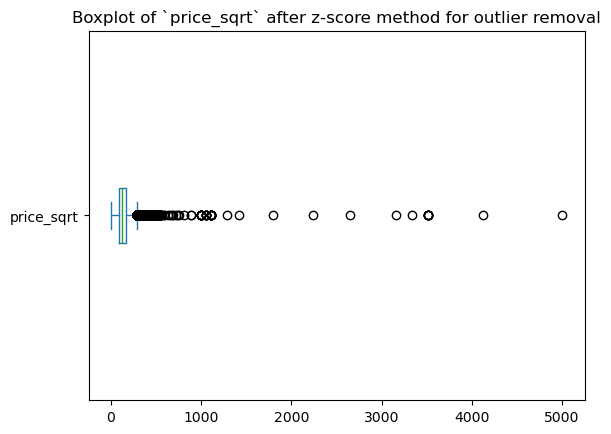

In [114]:
used_vehicle_data_zscore['price_sqrt'].plot(kind = 'box', vert = False, title = 'Boxplot of `price_sqrt` after z-score method for outlier removal')

#### IQR Method

In [116]:
iqr = used_vehicle_data['price'].quantile(0.75) - used_vehicle_data['price'].quantile(0.25) 
lower_bound = used_vehicle_data['price'].quantile(0.25) - 1.5*iqr
upper_bound = used_vehicle_data['price'].quantile(0.75) + 1.5*iqr

In [117]:
used_vehicle_data_iqr = used_vehicle_data[(used_vehicle_data['price'] > lower_bound) & (used_vehicle_data['price'] < upper_bound)].copy()
used_vehicle_data_iqr.shape[0]

386206

In [118]:
iqr_data_lost = 1 - (used_vehicle_data_iqr.shape[0]/used_vehicle_data.shape[0])
print("We lost {:.8%} of the data by the IQR method".format(iqr_data_lost))

We lost 1.97444065% of the data by the IQR method


In [119]:
used_vehicle_data_iqr['price'].describe()

count   386206.00
mean     17777.62
std      12821.82
min          1.00
25%       6999.00
50%      14995.00
75%      26950.00
max      58448.00
Name: price, dtype: float64

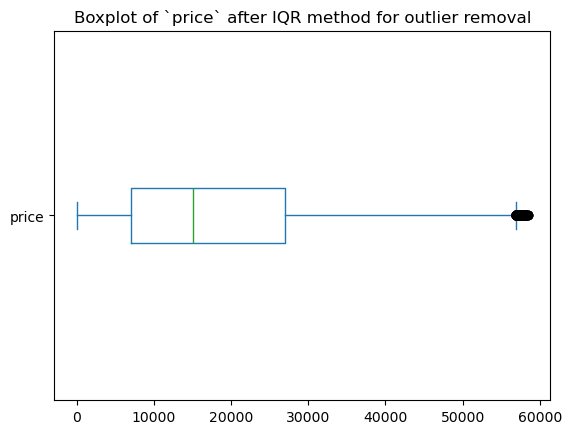

In [120]:
used_vehicle_data_iqr['price'].plot(kind = 'box', vert = False, title = 'Boxplot of `price` after IQR method for outlier removal');

The IQR method for removing outliers appears to work much more effective at removing the outliers.

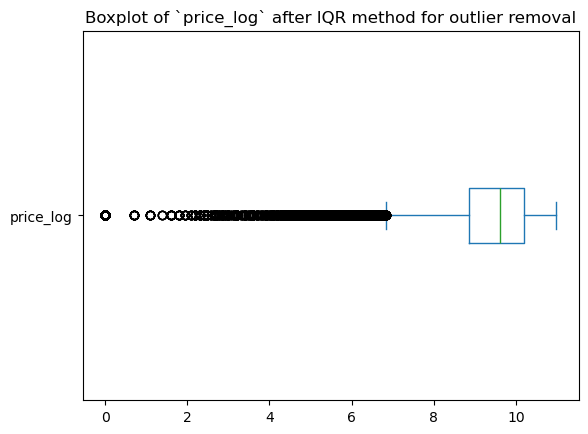

In [122]:
used_vehicle_data_iqr['price_log'].plot(kind = 'box', vert = False, title = 'Boxplot of `price_log` after IQR method for outlier removal');

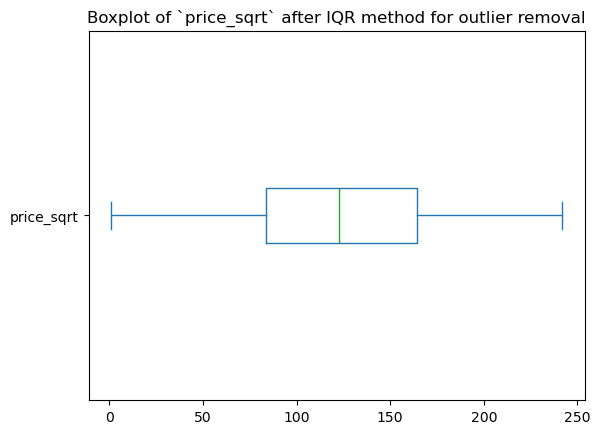

In [123]:
used_vehicle_data_iqr['price_sqrt'].plot(kind = 'box', vert = False, title = 'Boxplot of `price_sqrt` after IQR method for outlier removal');

This boxplot shows the outliers have been trimmed and there does not appear to be any extreme skewness.

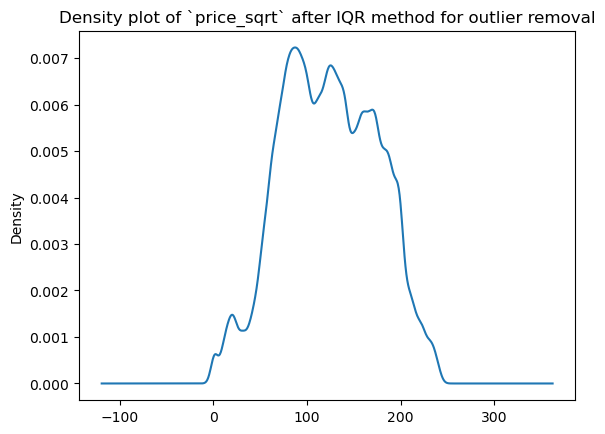

In [125]:
used_vehicle_data_iqr['price_sqrt'].plot(kind = 'density', title = 'Density plot of `price_sqrt` after IQR method for outlier removal');

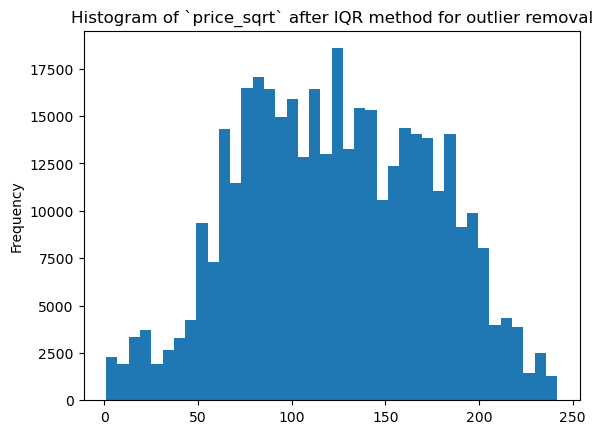

In [126]:
used_vehicle_data_iqr['price_sqrt'].plot(kind = 'hist', bins = 40, title = 'Histogram of `price_sqrt` after IQR method for outlier removal');

This looks beautiful. We have trimmed the outliers, and transformed `price` to be normally distributed as `price_sqrt`

### Bivariate Analysis

#### Numerical Value Relationships

In [130]:
corr = used_vehicle_data_iqr.corr(numeric_only=True)

#### Triangular Heatmap

In [132]:
mask = np.triu(np.ones_like(used_vehicle_data_iqr.corr(numeric_only = True).round(2)))

<Axes: >

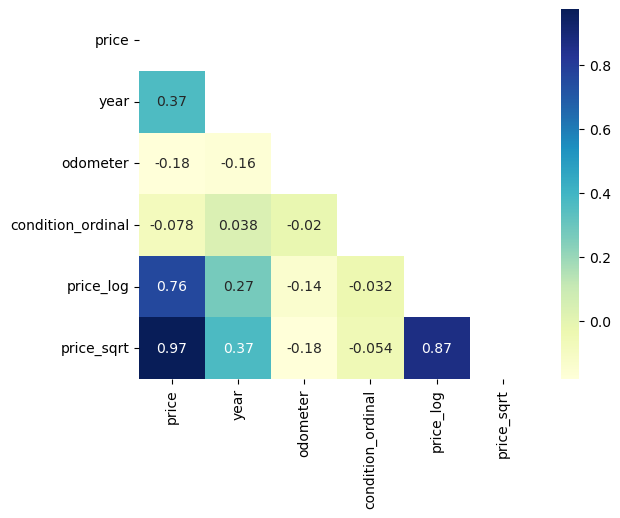

In [133]:
sns.heatmap(corr, annot = True, mask = mask, cmap = "YlGnBu")

Positive correlation betwween `year` and `price`, and a negative correlation between `odometer` and `price`. The correlation is stronger with `price_sqrt`.

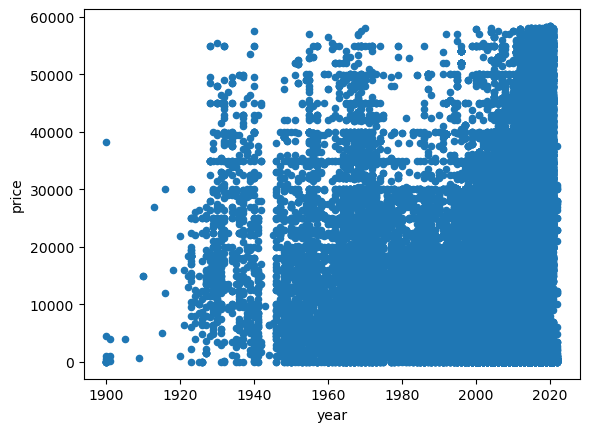

In [135]:
used_vehicle_data_iqr.plot(kind = 'scatter', x = 'year', y = 'price');

Here we can see a small positive correlation between `year` and `price`, as was demonstrated in the correlation plot. I do think that there is a lot of noise in the data, and we will likely need to include categorical variables to control for this in the regression.

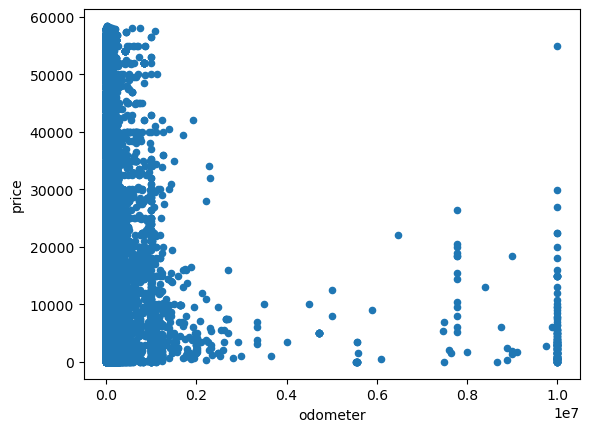

In [137]:
used_vehicle_data_iqr.plot(kind = 'scatter', x = 'odometer', y = 'price');

Here we can see a small negative correlation between `year` and `price`, as was demonstrated in the correlation plot. I do think that there is a lot of noise in the data, and we will likely need to include categorical variables to control for this in the regression. It should also be noted that there appears to be a parabolic shape. This is likely because the older classic cars have lots of mileage on the odometer, but are still highly valuable as a collectable item and because used cars with less miles tend to sell for more.

#### Categorical Variable Relationships

In [140]:
object_columns = used_vehicle_data_iqr.select_dtypes('object').columns

for object in object_columns:
    print(object, ':', used_vehicle_data_iqr[object].unique())
    print(used_vehicle_data_iqr[object].nunique(), ' Unique Values')

cylinders : [nan '8 cylinders' '6 cylinders' '4 cylinders' '5 cylinders' 'other'
 '3 cylinders' '10 cylinders' '12 cylinders']
8  Unique Values
fuel : [nan 'gas' 'other' 'diesel' 'hybrid' 'electric']
5  Unique Values
title_status : [nan 'clean' 'rebuilt' 'lien' 'salvage' 'missing' 'parts only']
6  Unique Values
transmission : [nan 'other' 'automatic' 'manual']
3  Unique Values
drive : [nan 'rwd' '4wd' 'fwd']
3  Unique Values
type : [nan 'pickup' 'truck' 'other' 'coupe' 'SUV' 'hatchback' 'mini-van' 'sedan'
 'offroad' 'bus' 'convertible' 'wagon' 'van']
13  Unique Values
paint_color : [nan 'white' 'blue' 'red' 'black' 'silver' 'grey' 'brown' 'yellow'
 'orange' 'green' 'custom' 'purple']
12  Unique Values
manufacturer_region : [nan 'North America' 'Asia' 'Europe']
3  Unique Values
state_region : ['West Mountain' 'South West South Central' 'South South Atlantic'
 'Northeast New England' 'Northeast Middle Atlantic' 'West Pacific'
 'Midwest East North Central' 'South East South Central'
 'Mid

Above we can see each of the current categorical variables and the levels contained in each. Since we screened our data previously for categorical variables with too many levels, we now have at maximum 12 levels.

##### `manufacturer_region`

In [143]:
used_vehicle_data_iqr.groupby('manufacturer_region')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
manufacturer_region,,,,,,,,
Asia,120654.00,14799.05,10632.60,1.00,6500.00,11995.00,20990.00,58000.00
Europe,51652.00,19449.11,12618.81,1.00,8990.00,17590.00,28900.00,58000.00
North America,198535.00,19230.10,13626.44,1.00,7500.00,16590.00,29590.00,58448.00


Just upon an initial glance it looks like the mean of European and North American cars is roughly the same and higher than the cars manufactured in Asia. The spread of the price also appears to be relatively similar across each `manufacturer_region`.

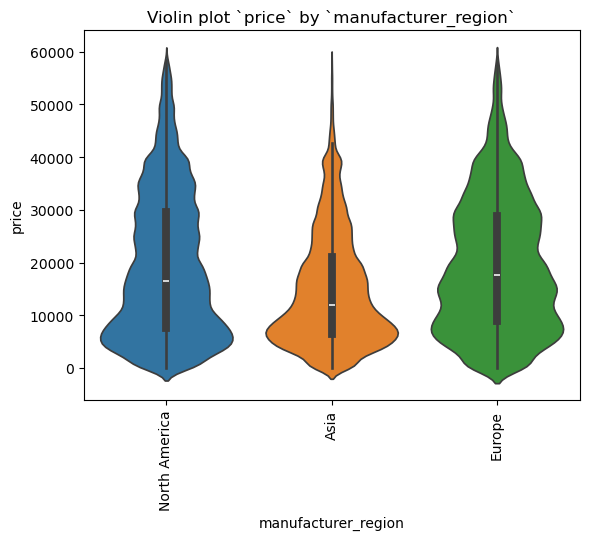

In [145]:
sns.violinplot(x = 'manufacturer_region', y = 'price', data = used_vehicle_data_iqr, hue = 'manufacturer_region')
# Rotate x-axis labels 45 degrees
plt.xticks(rotation=90)

# Hide the legend
plt.legend([], [], frameon=False)

plt.title("Violin plot `price` by `manufacturer_region`")

# Display the plot
plt.show()

A similar story is told when we take a look at the violin plot. However, we also see that the `price` distribution is rightly skewed for each region. This could be still informative to our model, since the means very slighlty as well as standard deviation from one region to the next.

##### `cylinders`

In [148]:
used_vehicle_data_iqr.groupby('cylinders')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
cylinders,,,,,,,,
10 cylinders,1323.00,17163.36,13662.48,1.00,5675.00,14995.00,26990.00,57000.00
12 cylinders,145.00,21042.99,15065.61,1.00,9500.00,19000.00,35000.00,53500.00
3 cylinders,608.00,12442.57,9306.88,1.00,5960.00,9995.00,18073.00,57500.00
4 cylinders,72944.00,11038.35,7981.98,1.00,5495.00,8995.00,14995.00,57645.00
5 cylinders,1667.00,7679.60,5772.45,1.00,4000.00,6495.00,9024.50,56000.00
6 cylinders,87658.00,17760.78,12871.94,1.00,6500.00,14995.00,27990.00,58200.00
8 cylinders,64164.00,21810.06,14106.89,1.00,9500.00,19950.00,32995.00,58444.00
other,1005.00,16705.69,14213.96,1.00,5900.00,12000.00,24995.00,57999.00


There appears to be much more variability between groups here. It appears that in-general a higher amount of cylinders means a higher price. However, after 8 cylinders it does seem to vary more. This is also likely due to there being fewer vehicles with 12 cylinders. Again, we will leave this as a categorical variable, since our other category indicates sometimes vehicles without cylinders.

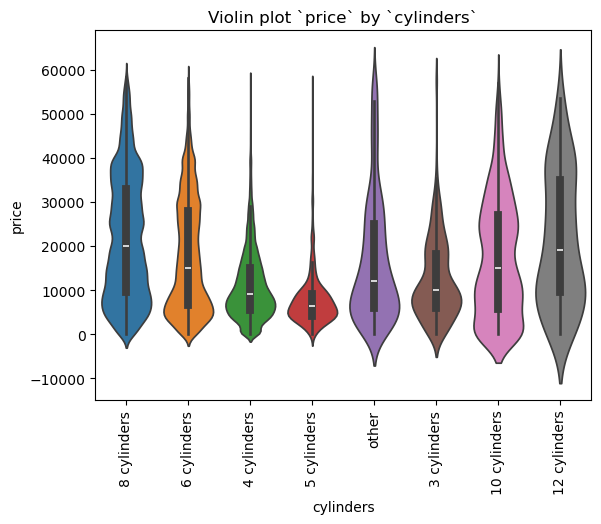

In [150]:
sns.violinplot(x = 'cylinders', y = 'price', data = used_vehicle_data_iqr, hue = 'cylinders')
# Rotate x-axis labels 45 degrees
plt.xticks(rotation=90)

# Hide the legend
plt.legend([], [], frameon=False)

plt.title("Violin plot `price` by `cylinders`")

# Display the plot
plt.show()

Again, it looks like there is a decent amount of variablity from one group to the next. It does look like there is more variablity in price for the larger cylinder vehicles. They also appear to be potentially bimodal. Finally, it looks like all of the categories are rightly skewed, but the other cylinder vehicles are the most skewed in-general.

##### `fuel`

In [153]:
used_vehicle_data_iqr.groupby('fuel')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
fuel,,,,,,,,
diesel,22946.00,28254.18,15270.96,1.00,15500.00,28000.00,39991.00,58444.00
electric,1563.00,23811.69,13756.50,1.00,11990.00,22777.00,36590.00,57995.00
gas,327115.00,16326.94,12131.25,1.00,6500.00,13000.00,24500.00,58448.00
hybrid,4855.00,15089.70,10404.51,1.00,7400.00,12731.00,19990.00,56999.00
other,27178.00,26344.17,11373.63,1.00,18770.00,26990.00,33990.00,58288.00


Diesel and electric vehicles appear to sell for more on average, as well as those in the 'other' category. Some other fuel types could be plug-in hybrid or hydrogen powered. These vehcile also ten to sell for more.

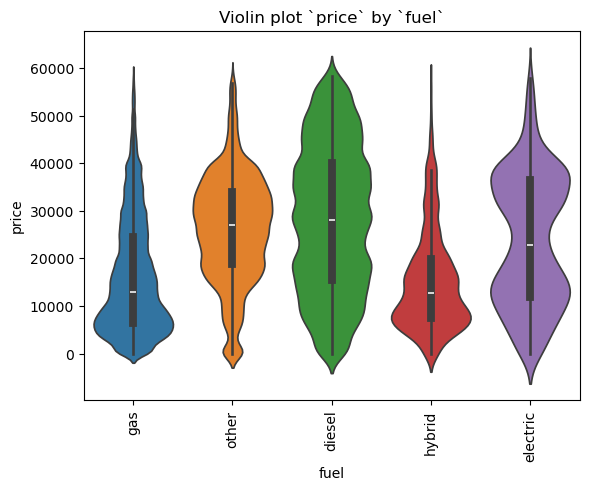

In [155]:
sns.violinplot(x = 'fuel', y = 'price', data = used_vehicle_data_iqr, hue = 'fuel')
# Rotate x-axis labels 45 degrees
plt.xticks(rotation=90)

# Hide the legend
plt.legend([], [], frameon=False)

plt.title("Violin plot `price` by `fuel`")

# Display the plot
plt.show()

There appears to be a lot of variability between groups here. We know that the means are all slightly different with diesel, electric and other being the most expensive used cars on average. However, from looking at this violin plot we can also see that gas and hybrid vehciles are unimodal and rightly skewed, but electic is very clearly bimodal and not clearly skewed. Diesel is also not skewed in either direction, and other is very slightly left skewed. This could be a very valuable predictor in our models.

##### `title_status`

In [158]:
used_vehicle_data_iqr.groupby('title_status')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
title_status,,,,,,,,
clean,365404.00,18064.98,12876.47,1.00,7200.00,15293.00,26995.00,58448.00
lien,1362.00,19881.79,12476.67,1.00,10000.00,17000.00,27000.00,57875.00
missing,785.00,4993.20,7037.99,1.00,1000.00,2500.00,6000.00,49000.00
parts only,188.00,3250.14,5618.06,1.00,500.00,1200.00,3500.00,50000.00
rebuilt,7120.00,12688.13,8967.06,1.00,6537.50,10495.00,16000.00,57000.00
salvage,3820.00,9432.55,8084.54,1.00,3850.00,7150.00,12800.00,57500.00


`title_status` appears to have a lot of variablity betwen groups. There are only two categories that appear to be very similar in variance and mean: 'clean' and 'lien'. 'clean' and 'lien' are typically good title statuses, so this makes sense.

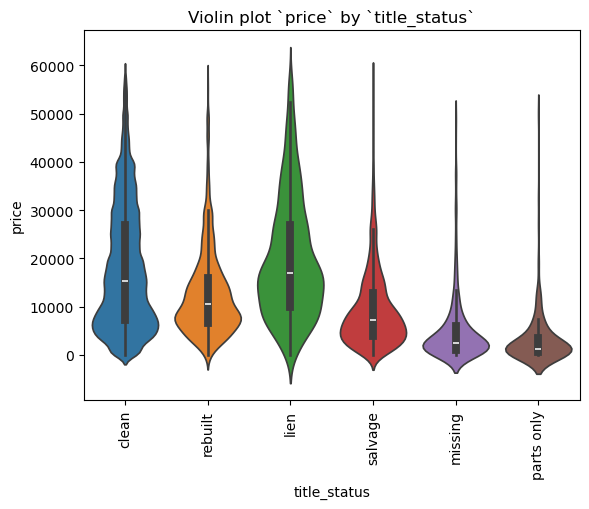

In [160]:
sns.violinplot(x = 'title_status', y = 'price', data = used_vehicle_data_iqr, hue = 'title_status')
# Rotate x-axis labels 45 degrees
plt.xticks(rotation=90)

# Hide the legend
plt.legend([], [], frameon=False)

plt.title("Violin plot `price` by `title_status`")

# Display the plot
plt.show()

Here we can see that all of the categories are rightly skewed with `price`. The best price is given for vehciles in a good title status, and it looks like there is more variability in those prices compared to not the best statuses for a title. I think this will be very informative.

##### `transmission`

In [163]:
used_vehicle_data_iqr.groupby('transmission')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
transmission,,,,,,,,
automatic,299847.00,16047.40,12490.44,1.00,6499.00,12595.00,22995.00,58448.00
manual,23346.00,13531.46,11618.69,1.00,4999.00,9900.00,18953.25,58000.00
other,61256.00,27854.87,9703.41,1.00,20990.00,28590.00,34990.00,57990.00


Here we might see the most distinct differences yet. We see that 'other' sells for the most, then 'automatic', and finally 'manual', on average. The spread of each looks pretty similar, but 'other' appears to have the least variablity within the group.

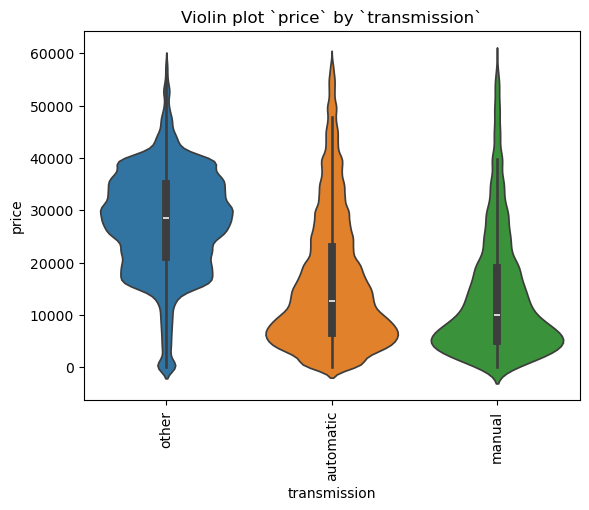

In [165]:
sns.violinplot(x = 'transmission', y = 'price', data = used_vehicle_data_iqr, hue = 'transmission')
# Rotate x-axis labels 45 degrees
plt.xticks(rotation=90)

# Hide the legend
plt.legend([], [], frameon=False)

plt.title("Violin plot `price` by `transmission`")


# Display the plot
plt.show()

As we can see, the 'other' category is actually relatively normally distributed and has the smallest spread. The 'automatic' and 'manual' categories are both rightly skewed and have very similar shape. They are not normall distributed.

##### `drive`

In [168]:
used_vehicle_data_iqr.groupby('drive')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
drive,,,,,,,,
4wd,116063.00,21533.64,14069.25,1.00,9500.00,19500.00,31998.00,58448.00
fwd,97365.00,12421.25,8704.00,1.00,5950.00,10000.00,17250.00,58200.00
rwd,54328.00,19862.27,12617.26,1.00,8980.00,18500.00,29591.25,58000.00


Here we can see that the mean price is different for each of the groups. The variability within each group is different, with '4wd' having the highest, but is relatively close to the variability within 'rwd'.

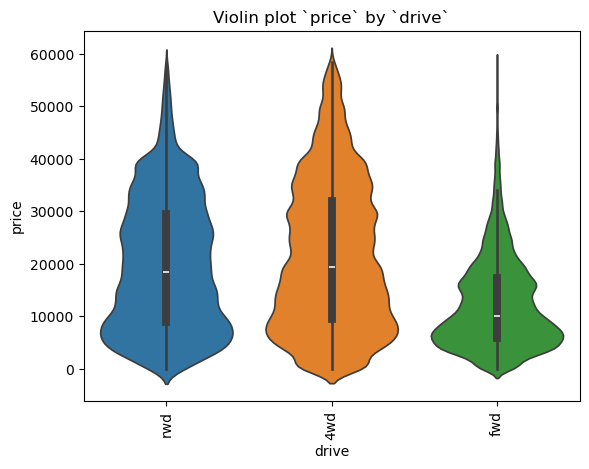

In [170]:
sns.violinplot(x = 'drive', y = 'price', data = used_vehicle_data_iqr, hue = 'drive')
# Rotate x-axis labels 45 degrees
plt.xticks(rotation=90)

# Hide the legend
plt.legend([], [], frameon=False)

plt.title("Violin plot `price` by `drive`")

# Display the plot
plt.show()

Each of the distributions are rightly skewed, with 'fwd' being heavily rightly skewed. This column will likely be another decent predictor in our model.

##### `type`

In [173]:
used_vehicle_data_iqr.groupby('type')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
SUV,69921.00,17008.03,11736.75,1.00,7950.00,14600.00,23998.00,58288.00
bus,497.00,14262.78,11276.17,1.00,5995.00,11500.00,21900.00,50427.00
convertible,7131.00,17709.28,11939.27,1.00,8000.00,15000.00,25000.00,57500.00
coupe,17672.00,20772.99,13483.36,1.00,8988.75,18999.00,31990.00,58000.00
hatchback,15906.00,14956.42,9347.10,1.00,6999.00,14590.00,19990.00,55997.00
mini-van,4543.00,9665.66,7802.95,1.00,4000.00,7300.00,12950.00,54000.00
offroad,586.00,15613.95,11325.81,1.00,7000.00,12500.00,23000.00,54500.00
other,19240.00,25934.59,12172.33,1.00,16990.00,26995.00,34990.00,58200.00
pickup,39784.00,27056.44,12474.72,1.00,18000.00,27990.00,34999.00,58000.00


There does appear to be some variability between the categories here, with most of the spreads being very similar. The most expsenive category appears to be 'pickup', and the cheapest category looks to be 'minivan'. There also appears to be a decent amount of rows for each of the categories. Some of the categories seem a bit less spread out like: 'mini-van', 'wagon', and 'hatchback'. This column should be helpful in our model. Overall, it looks like this category might be good at capturing the how the size of different vehicles influences price as well. It looks like, in-general, larger vehicles sell for more on average unless they are sports cars like coupes.

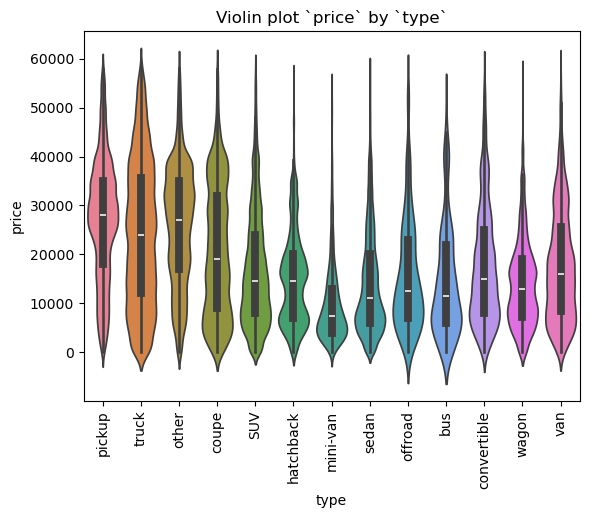

In [175]:
sns.violinplot(x = 'type', y = 'price', data = used_vehicle_data_iqr, hue = 'type')
# Rotate x-axis labels 45 degrees
plt.xticks(rotation=90)

# Hide the legend
plt.legend([], [], frameon=False)

plt.title("Violin plot `price` by `type`")

# Display the plot
plt.show()

Our violin plot tells a similar story, We can also see that amonst all of the variables are heavily rightly skewed except for 'pickup', 'truck', and 'other'. 'pickup' and 'truck' don't appear to be too skewed in either direction while other looks slightly left skewed. This could be that motorcycles drive influence this skewness in the 'other' category. 'hatchback' appears to be bimodal which could be due to the influence of hatchbacks that are considered 'hot-hatchbacks' that are for sports performance and traditional performance hatchbacks.

##### `paint_color`

In [178]:
used_vehicle_data_iqr.groupby('paint_color')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
paint_color,,,,,,,,
black,56972.00,20471.68,12864.04,1.00,9750.00,18000.00,29995.00,58250.00
blue,29096.00,16428.12,11993.52,1.00,6500.00,13500.00,24500.00,58000.00
brown,6139.00,15715.22,11984.51,1.00,5900.00,11995.00,24990.00,57995.00
custom,6328.00,15312.24,11573.13,1.00,6586.25,12299.50,21701.75,57999.00
green,7019.00,12634.57,11055.32,1.00,4499.00,8700.00,17500.00,57999.00
grey,22479.00,14717.70,11265.67,1.00,6500.00,11495.00,19995.00,58000.00
orange,1825.00,18354.43,11357.12,1.00,8997.00,17995.00,25590.00,56990.00
purple,661.00,13862.03,11839.92,1.00,4995.00,9900.00,19990.00,58000.00
red,28296.00,18467.71,12421.26,1.00,7900.00,15995.00,27990.00,58288.00


There is some variation in the mean from once group to the next, but it looks like on average 'black' and 'white' cars sell for more. It looks like the spread is also remarkably similar across each group.

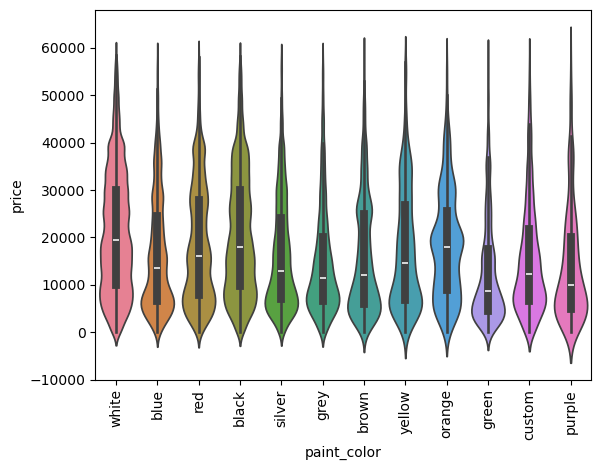

In [180]:
sns.violinplot(x = 'paint_color', y = 'price', data = used_vehicle_data_iqr, hue = 'paint_color')
# Rotate x-axis labels 45 degrees
plt.xticks(rotation=90)

# Hide the legend
plt.legend([], [], frameon=False)

# Display the plot
plt.show()

Each of the 'paint_color' categories is rightly skewed, and does not show anything quite remarkable apart from 'orange' having a median near the medians of the 'black' and 'white' categories. This was not as obvious at first since I was looking at the mean. This means that 'orange' color cars also sell for higher prices on average, like 'black' and 'white' color cars.

##### `state_region`

In [183]:
used_vehicle_data_iqr.groupby('state_region')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
state_region,,,,,,,,
Midwest East North Central,59130.00,16182.90,12307.85,1.00,5995.00,12900.00,24990.00,58200.00
Midwest West North Central,27609.00,17799.93,12359.76,1.00,7900.00,14995.00,25950.00,58444.00
Northeast Middle Atlantic,39712.00,16403.90,12173.44,1.00,6499.00,12990.00,24990.00,58000.00
Northeast New England,23239.00,15148.94,11943.74,1.00,5995.00,11995.00,22777.00,57990.00
South East South Central,20050.00,19657.72,12122.85,1.00,9500.00,17990.00,28500.00,58000.00
South South Atlantic,68671.00,18022.49,12857.92,1.00,6995.00,15500.00,27500.00,58250.00
South West South Central,32128.00,19842.37,13289.31,1.00,7999.00,17988.00,29901.50,58200.00
West Mountain,40116.00,19539.01,13269.13,1.00,8500.00,16995.00,28900.00,58448.00
West Pacific,75551.00,18013.37,13295.29,1.00,7500.00,14995.00,26920.00,58288.00


I think this is really interesting because of what it may capture. If we take a look at the regions that are in the north, we can see that on average they sell for less than those from the south. This is most likely due to the harsh winters that vehicles have to face up north. In the winter, roadways and parking lots are salted heavily which means that cars face corrosion at much higher rates than those of cars in the south. We also see a very similar spread for each of the regions.

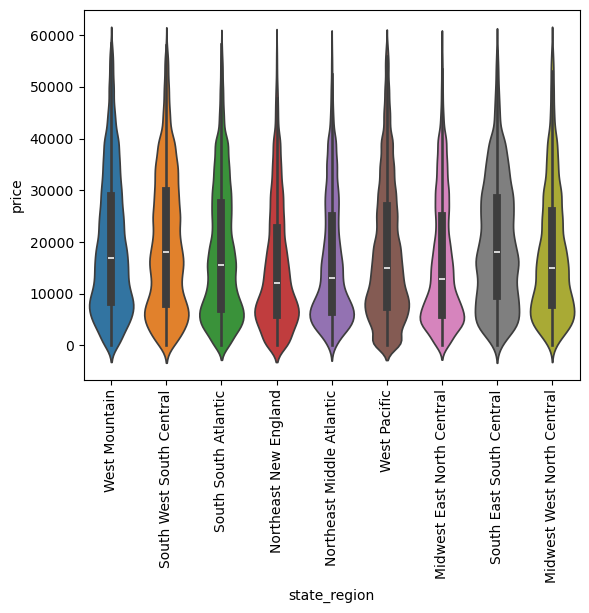

In [185]:
sns.violinplot(x = 'state_region', y = 'price', data = used_vehicle_data_iqr, hue = 'state_region')
# Rotate x-axis labels 45 degrees
plt.xticks(rotation=90)

# Hide the legend
plt.legend([], [], frameon=False)

# Display the plot
plt.show()

Again, it looks like all of these variables are rightly skewed. Looking back at why these most of the time tend to be rightly skewed is indicative of not only the spread of price, but a pattern in the data. There are still some cars that sell for higher prices in most of these categories across most of the categorical columns, causing the right skew. I believe that these cars are probably collector cars or have fanbases that drive up the price.

# **Data Preprocessing**
## _Preparing Data for Multiple, Ridge, and Lasso Regression_

---

In [188]:
used_vehicle_data_iqr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386206 entries, 7222695916 to 7301591129
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   price                386206 non-null  int64  
 1   year                 385218 non-null  float64
 2   cylinders            229514 non-null  object 
 3   fuel                 383657 non-null  object 
 4   odometer             383994 non-null  float64
 5   title_status         378679 non-null  object 
 6   transmission         384449 non-null  object 
 7   drive                267756 non-null  object 
 8   type                 301965 non-null  object 
 9   paint_color          271400 non-null  object 
 10  manufacturer_region  370841 non-null  object 
 11  condition_ordinal    239836 non-null  float64
 12  state_region         386206 non-null  object 
 13  price_log            386206 non-null  float64
 14  price_sqrt           386206 non-null  float64
dtypes: float6

We currently have 4 numeric variables (exlcuding `price` and `price_log`) and 9 categorical variables.

In [190]:
used_vehicle_data_iqr.drop(columns = ['price_log', 'price'], inplace = True)

We drop `price_log` and `price`, since `price_sqrt` was chosen as the response variable sense it is most normally distributed.

In [192]:
used_vehicle_data_iqr.isna().mean().round(4)*100

year                   0.26
cylinders             40.57
fuel                   0.66
odometer               0.57
title_status           1.95
transmission           0.45
drive                 30.67
type                  21.81
paint_color           29.73
manufacturer_region    3.98
condition_ordinal     37.90
state_region           0.00
price_sqrt             0.00
dtype: float64

We still have a lot of missing values that we will want to impute. For now, we will focus on imputing those columns with less than 5% missing data. But first, we need to split the data!

## Train/Validation/Test Split

Let's split the data into 70/15/15 for the training, validation, and test sets, respectively. I will also exclude `cylinders`, `drive`, `type`, `paint_color`, and `condition_ordinal`. These variables have a lot of missing data, and we may not need them to build an effective model. If our models still leave something to be desired, we can explore including these features.

In [196]:
# Assuming your data is in a pandas DataFrame named 'df'
X = used_vehicle_data_iqr.drop(columns = ['price_sqrt'], axis=1)  # Features
y = used_vehicle_data_iqr['price_sqrt']  # Target variable

# First split: 85% for training and validation, 15% for testing
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: 80% of the 85% for training, 20% for validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=(0.15/0.85), random_state=42)

In [197]:
X_val.shape[0]/X.shape[0]

0.15000025892917251

In [198]:
X_test.shape[0]/X.shape[0]

0.15000025892917251

In [199]:
X_train.shape[0]/X.shape[0]

0.699999482141655

As we can see we have split the dataset where the training, validation, and test sets are 70%, 15%, and 15% of the data, respectively.

## Missing Value Imputation

In [202]:
used_vehicle_data_iqr.drop(columns = ['price_sqrt', 'cylinders', 'drive', 'type', 'paint_color', 'condition_ordinal'], axis=1).isna().mean().round(8)*100

year                  0.26
fuel                  0.66
odometer              0.57
title_status          1.95
transmission          0.45
manufacturer_region   3.98
state_region          0.00
dtype: float64

We will impute all variables except for `state_region`, because there are no missing values.

In [204]:
print(X_train.isna().sum())
print(X_val.isna().sum())
print(X_test.isna().sum())

year                      715
cylinders              109551
fuel                     1824
odometer                 1546
title_status             5304
transmission             1232
drive                   82903
type                    58877
paint_color             80341
manufacturer_region     10766
condition_ordinal      102477
state_region                0
dtype: int64
year                     152
cylinders              23492
fuel                     335
odometer                 330
title_status            1070
transmission             252
drive                  17721
type                   12562
paint_color            17164
manufacturer_region     2357
condition_ordinal      21889
state_region               0
dtype: int64
year                     121
cylinders              23649
fuel                     390
odometer                 336
title_status            1153
transmission             273
drive                  17826
type                   12802
paint_color            17301
manuf

As we can see, there are missing values in the train, validation, and test splits.

In [206]:
from sklearn import set_config
set_config(transform_output="pandas") #set output to pd.DataFrame

In [207]:
from sklearn.impute import SimpleImputer

In [208]:
# initiate median imputer for numeric columns
num_imputer = SimpleImputer(strategy = "median")

# intitiate most frequent imputer for categorical columns
cat_imputer = SimpleImputer(strategy= "most_frequent")

We will use the median to impute the numeric columns due to the skewness in the dataset. We will then select the most frequent category to impute the categorical variables.

In [210]:
# Separate numeric and categorical columns
least_missing_numeric_cols = X_train.drop(columns = ['cylinders', 'condition_ordinal'], axis = 1).select_dtypes(include=['number']).columns
numeric_cols = X_train.select_dtypes(include=['number']).columns
least_missing_categorical_cols = X_train.drop(columns = ['cylinders', 'drive', 'type', 'paint_color'], axis = 1).select_dtypes(exclude=['number']).columns
categorical_cols = X_train.select_dtypes(exclude=['number']).columns
least_missing_cols = list(least_missing_numeric_cols) + list(least_missing_categorical_cols)


print(numeric_cols, categorical_cols)
print(least_missing_numeric_cols, least_missing_categorical_cols)

Index(['year', 'odometer', 'condition_ordinal'], dtype='object') Index(['cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type',
       'paint_color', 'manufacturer_region', 'state_region'],
      dtype='object')
Index(['year', 'odometer'], dtype='object') Index(['fuel', 'title_status', 'transmission', 'manufacturer_region',
       'state_region'],
      dtype='object')


In [211]:
#fit_transform on train, transform on val and test

#train
X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
X_train[categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])

#val
X_val[numeric_cols] = num_imputer.transform(X_val[numeric_cols])
X_val[categorical_cols] = cat_imputer.transform(X_val[categorical_cols])

#test
X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])
X_test[categorical_cols] = cat_imputer.transform(X_test[categorical_cols])

Here we fit and transform the training dataset, and then transform the validation and test sets. This is to prevent data leakage.

In [213]:
print(X_train.isna().sum())
print(X_val.isna().sum())
print(X_test.isna().sum())

year                   0
cylinders              0
fuel                   0
odometer               0
title_status           0
transmission           0
drive                  0
type                   0
paint_color            0
manufacturer_region    0
condition_ordinal      0
state_region           0
dtype: int64
year                   0
cylinders              0
fuel                   0
odometer               0
title_status           0
transmission           0
drive                  0
type                   0
paint_color            0
manufacturer_region    0
condition_ordinal      0
state_region           0
dtype: int64
year                   0
cylinders              0
fuel                   0
odometer               0
title_status           0
transmission           0
drive                  0
type                   0
paint_color            0
manufacturer_region    0
condition_ordinal      0
state_region           0
dtype: int64


As we can see, there are now no missing values in any of the training, validation, or testing datasets.

# **Model Building**
---

We will use RMSE for our model evaluation. This is because MSE can be quite big due to the size of price_sqrt and price. So, this metrics is a bit easier to look at.

In [216]:
y_train.mean().round(3)

123.337

This mean across all of y_train is what we will use to predict all values in the validation set to establish a baseline model.

## Baseline Model

In [219]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor()

In [220]:
#fit the model
dummy.fit(X_train, y_train)

DummyRegressor()

In [463]:
#R^2 of the model
dummy_r2 = dummy.score(X_train, y_train)
print("Dummy R Squared of : {:.2f}".format(dummy_r2))
dummy_r2_test = dummy.score(X_test, y_test)

#predictions on the validation set
dummy_predict = dummy.predict(X_val)

#prediction on the test set
dummy_predict_test = dummy.predict(X_test)

#RMSE of validation set
dummy_rmse = np.sqrt(mean_squared_error(y_val, dummy_predict))

#RMSE of test set
dummy_rmse_test = np.sqrt(mean_squared_error(y_test, dummy_predict_test))

print("Dummy Validation Set RMSE of : {:.2f}".format(dummy_rmse))


print("Dummy Test R Squared of : {:.5f}".format(dummy_r2_test))
print("Dummy Test Set RMSE of : {:.2f}".format(dummy_rmse_test))

Dummy R Squared of : 0.00
Dummy Validation Set RMSE of : 50.61
Dummy Test R Squared of : -0.00002
Dummy Test Set RMSE of : 50.72


In [222]:
y_val.head()

id
7303599854   130.36
7316774928   216.79
7303760301   151.62
7303419032    70.68
7310018969   116.19
Name: price_sqrt, dtype: float64

In [223]:
pd.Series(dummy_predict).head()

0   123.34
1   123.34
2   123.34
3   123.34
4   123.34
dtype: float64

As we can see each of the `dummy_predict` values is the mean of the `y_train`.

## Least Missing Numeric Columns:
### Linear Regression

In [226]:
num_lr = LinearRegression()

In [227]:
#fit the model
num_lr.fit(X_train[least_missing_numeric_cols], y_train)

#R^2 of the model
num_lr_r2 = num_lr.score(X_train[least_missing_numeric_cols], y_train)
print("num_lr R Squared of : {:.2f}".format(num_lr_r2))

#predictions on the validation set
num_lr_predict = num_lr.predict(X_val[least_missing_numeric_cols])

#RMSE of validation set
num_lr_rmse = np.sqrt(mean_squared_error(y_val, num_lr_predict))

print("num_lr Validation Set RMSE of : {:.2f}".format(num_lr_rmse))

num_lr R Squared of : 0.15
num_lr Validation Set RMSE of : 46.53


## Testing Different Polynomial Degrees for Numeric Variables

In [229]:
poly_model_rmse = {f'degree_{i}_rmse': 0 for i in range(1, 11)}

print(poly_model_rmse)

{'degree_1_rmse': 0, 'degree_2_rmse': 0, 'degree_3_rmse': 0, 'degree_4_rmse': 0, 'degree_5_rmse': 0, 'degree_6_rmse': 0, 'degree_7_rmse': 0, 'degree_8_rmse': 0, 'degree_9_rmse': 0, 'degree_10_rmse': 0}


In [230]:
for i in range(1, 11):
    pipe = Pipeline([('poly_features', PolynomialFeatures(degree = i, include_bias = False)), ('poly_model', LinearRegression())])
    pipe.fit(X_train[least_missing_numeric_cols], y_train)
    predict_val = pipe.predict(X_val[least_missing_numeric_cols])
    rmse = np.sqrt(mean_squared_error(y_val, predict_val))
    poly_model_rmse[f'degree_{i}_rmse'] = rmse

poly_model_rmse

{'degree_1_rmse': 46.53115513091829,
 'degree_2_rmse': 41.639647615687565,
 'degree_3_rmse': 43.39872783009703,
 'degree_4_rmse': 42.68685928520903,
 'degree_5_rmse': 43.96241504577839,
 'degree_6_rmse': 50.555477213213706,
 'degree_7_rmse': 50.5831724525948,
 'degree_8_rmse': 50.58668466862538,
 'degree_9_rmse': 50.58718867321752,
 'degree_10_rmse': 50.58757105220401}

Degree 2 looks best. Let's use that moving forward for the numeric variables.

41.27259658101989


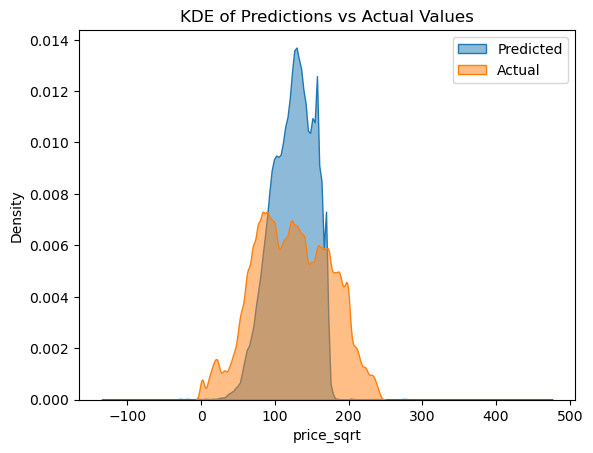

In [232]:
# Update the pipeline to include StandardScaler
num_pipe_degree2 = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),  # Standardize the features
    ('poly_model', LinearRegression())
])

num_pipe_degree2.fit(X_train[numeric_cols], y_train)
feature_names = num_pipe_degree2.named_steps['poly_features'].get_feature_names_out(input_features=numeric_cols)
predict_val = num_pipe_degree2.predict(X_val[numeric_cols])
rmse = np.sqrt(mean_squared_error(y_val, predict_val))
print(rmse)

sns.kdeplot(predict_val, label = 'Predicted', fill=True, alpha = 0.5, bw_adjust=0.5)
sns.kdeplot(y_val, label = 'Actual', fill = True, alpha = 0.5, bw_adjust=0.5)

plt.title("KDE of Predictions vs Actual Values")
plt.legend()
plt.show()

,Coefficients
year,-2444.78
odometer,26.43
condition_ordinal,737.53
year^2,2473.97
year odometer,-47.37
year condition_ordinal,-730.93
odometer^2,19.25
odometer condition_ordinal,-0.88
condition_ordinal^2,-8.58


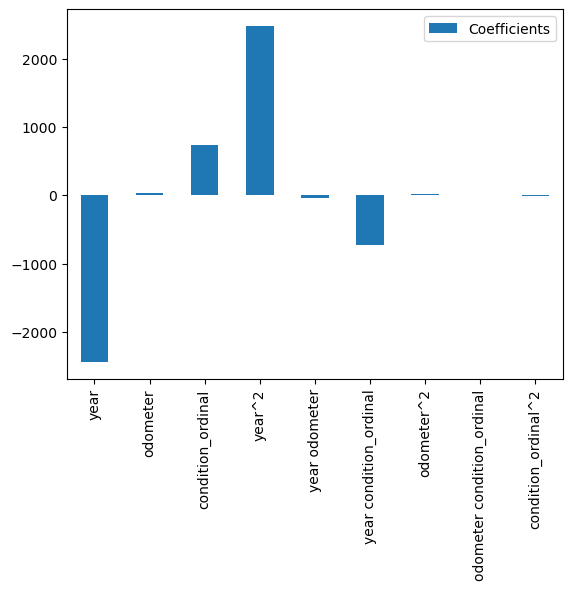

In [233]:
coefficients = pd.DataFrame(num_pipe_degree2.named_steps['poly_model'].coef_, feature_names, columns = ["Coefficients"])
display(coefficients)
coefficients.plot(kind = "bar");

### Ridge Regression

Validation RMSE: 41.63958722731767
Best Alpha: 0.001


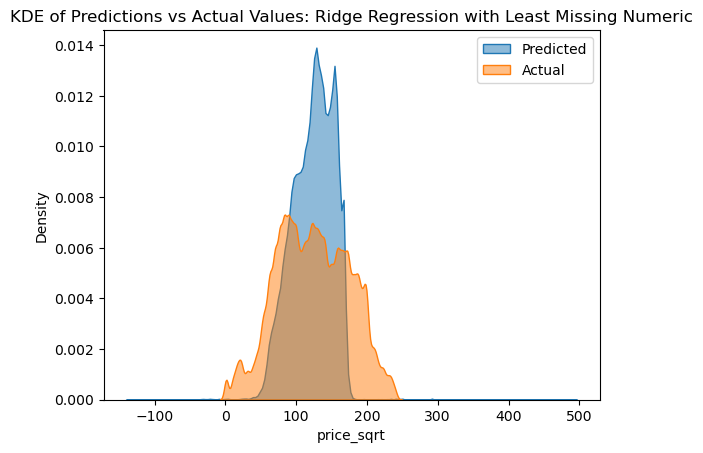

In [235]:
ridge_pipe = pipe = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),  # Standardize the features
    ('ridge_model', Ridge())
])

param_dict = {'ridge_model__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}

grid = GridSearchCV(ridge_pipe, param_grid=param_dict)
grid.fit(X_train[least_missing_numeric_cols], y_train)
train_preds = grid.predict(X_train[least_missing_numeric_cols])
val_preds = grid.predict(X_val[least_missing_numeric_cols])
model_train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
model_val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
model_best_alpha = grid.best_params_


print(f'Validation RMSE: {model_val_rmse}')
print(f'Best Alpha: {list(model_best_alpha.values())[0]}')

sns.kdeplot(val_preds, label = 'Predicted', fill=True, alpha = 0.5, bw_adjust=0.5)
sns.kdeplot(y_val, label = 'Actual', fill = True, alpha = 0.5, bw_adjust=0.5)

plt.title("KDE of Predictions vs Actual Values: Ridge Regression with Least Missing Numeric")
plt.legend()
plt.show()

,Coefficients
year,-2475.18
odometer,8.80
year^2,2491.65
year odometer,-31.55
odometer^2,20.02


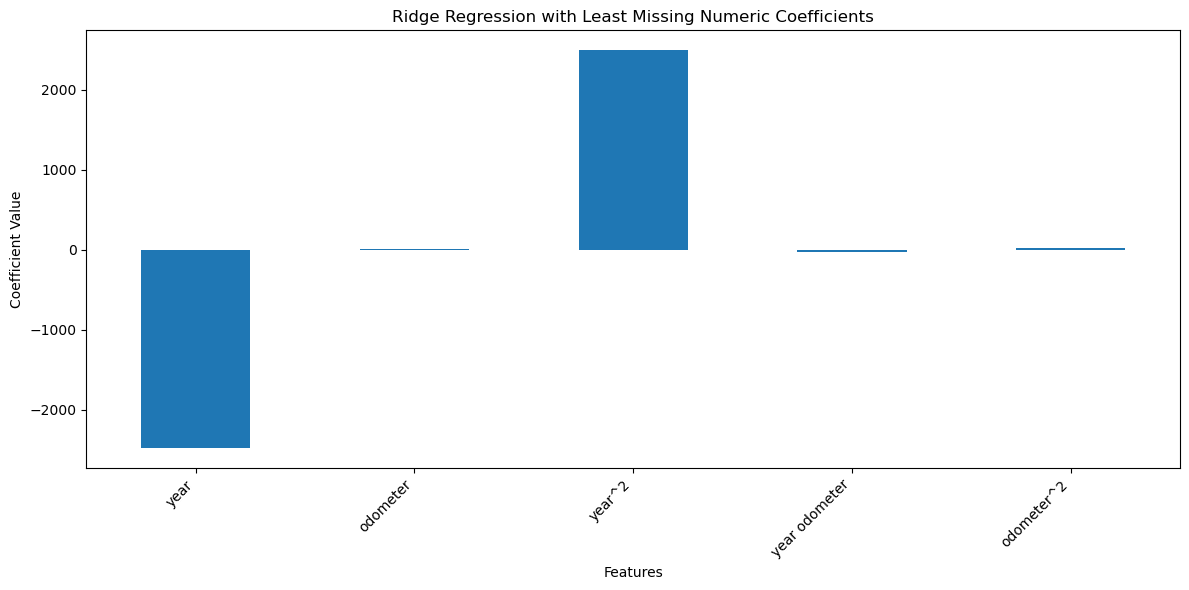

In [236]:
# Extract the best estimator from GridSearchCV
best_model = grid.best_estimator_

# Get the feature names from the PolynomialFeatures step
poly_features = best_model.named_steps['poly_features']
feature_names = poly_features.get_feature_names_out(input_features=least_missing_numeric_cols)

# Retrieve the coefficients from the Ridge model step
ridge_model = best_model.named_steps['ridge_model']
coefficients = pd.DataFrame(ridge_model.coef_, index=feature_names, columns=["Coefficients"])

# Display the coefficients DataFrame
display(coefficients)

# Plot the coefficients
coefficients.plot(kind="bar", figsize=(12, 6), legend=False)
plt.title("Ridge Regression with Least Missing Numeric Coefficients")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Lasso Regression

Validation RMSE: 44.092987000697605
Best Alpha: 0.001


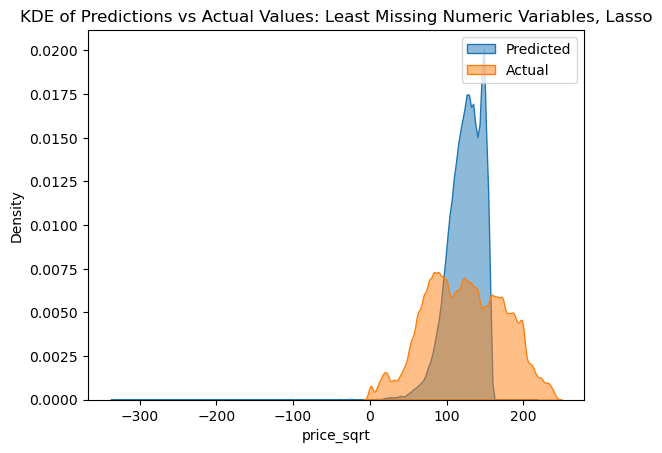

In [238]:
lasso_pipe = pipe = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),  # Standardize the features
    ('lasso_model', Lasso(random_state=21))
])

param_dict = {'lasso_model__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}

grid = GridSearchCV(lasso_pipe, param_grid=param_dict)
grid.fit(X_train[least_missing_numeric_cols], y_train)
train_preds = grid.predict(X_train[least_missing_numeric_cols])
val_preds = grid.predict(X_val[least_missing_numeric_cols])
model_train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
model_val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
model_best_alpha = grid.best_params_


print(f'Validation RMSE: {model_val_rmse}')
print(f'Best Alpha: {list(model_best_alpha.values())[0]}')

sns.kdeplot(val_preds, label = 'Predicted', fill=True, alpha = 0.5, bw_adjust=0.5)
sns.kdeplot(y_val, label = 'Actual', fill = True, alpha = 0.5, bw_adjust=0.5)

plt.title("KDE of Predictions vs Actual Values: Least Missing Numeric Variables, Lasso")
plt.legend()
plt.show()

,Coefficients
year,-76.08
odometer,-41.02
year^2,90.64
year odometer,0.32
odometer^2,36.86


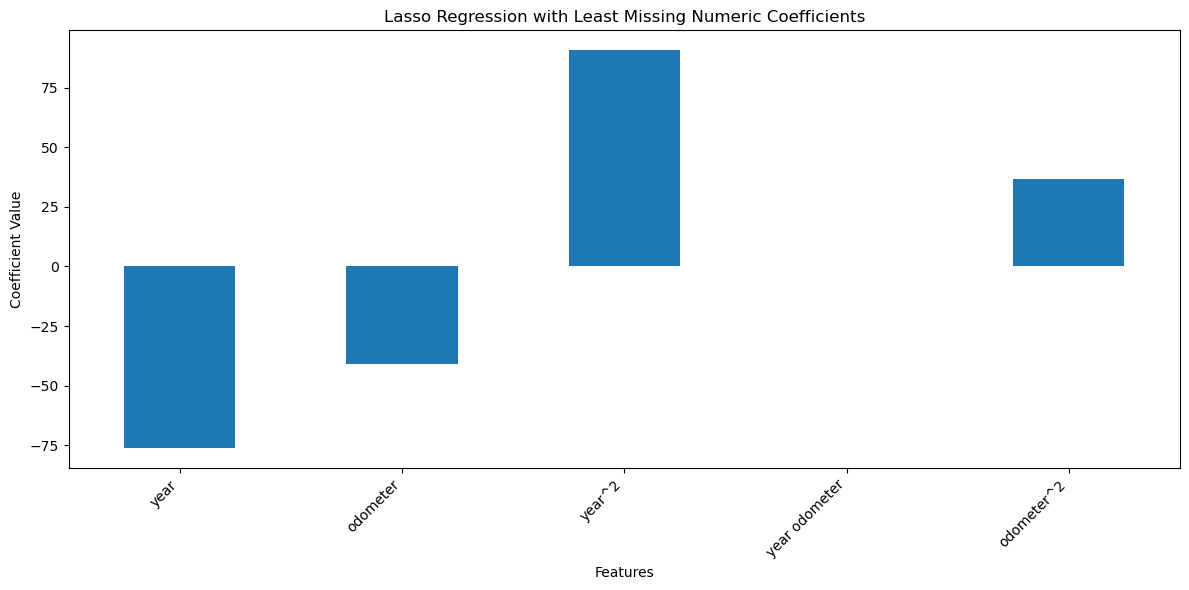

In [239]:
# Extract the best estimator from GridSearchCV
best_model = grid.best_estimator_

# Get the feature names from the PolynomialFeatures step
poly_features = best_model.named_steps['poly_features']
feature_names = poly_features.get_feature_names_out(input_features=least_missing_numeric_cols)

# Retrieve the coefficients from the Ridge model step
lasso_model = best_model.named_steps['lasso_model']
coefficients = pd.DataFrame(lasso_model.coef_, index=feature_names, columns=["Coefficients"])

# Display the coefficients DataFrame
display(coefficients)

# Plot the coefficients
coefficients.plot(kind="bar", figsize=(12, 6), legend=False)
plt.title("Lasso Regression with Least Missing Numeric Coefficients")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Least Missing Numeric and Categorical Columns:
### Linear Regression

In [241]:
# Reset the transform output to default
set_config(transform_output="default")

for i in range(1, 11):
    # Define preprocessing steps
    preprocessor = make_column_transformer((Pipeline([('poly_features', PolynomialFeatures(degree=i, include_bias=False)),
                                                      ('scaler', StandardScaler())]), least_missing_numeric_cols),
                                           (OneHotEncoder(handle_unknown='ignore'), least_missing_categorical_cols))
    pipe = Pipeline([('preprocessor', preprocessor), ('poly_model', LinearRegression())])
    pipe.fit(X_train[least_missing_cols], y_train)
    predict_val = pipe.predict(X_val[least_missing_cols])
    rmse = np.sqrt(mean_squared_error(y_val, predict_val))
    poly_model_rmse[f'degree_{i}_rmse'] = rmse

poly_model_rmse

{'degree_1_rmse': 42.258266103740475,
 'degree_2_rmse': 37.91629677038507,
 'degree_3_rmse': 36.733374756368384,
 'degree_4_rmse': 36.60914739733343,
 'degree_5_rmse': 36.51105776895936,
 'degree_6_rmse': 36.43804052444132,
 'degree_7_rmse': 36.40713153767512,
 'degree_8_rmse': 36.37767005049745,
 'degree_9_rmse': 36.36315393302667,
 'degree_10_rmse': 36.359205844534785}

36.733374756368384


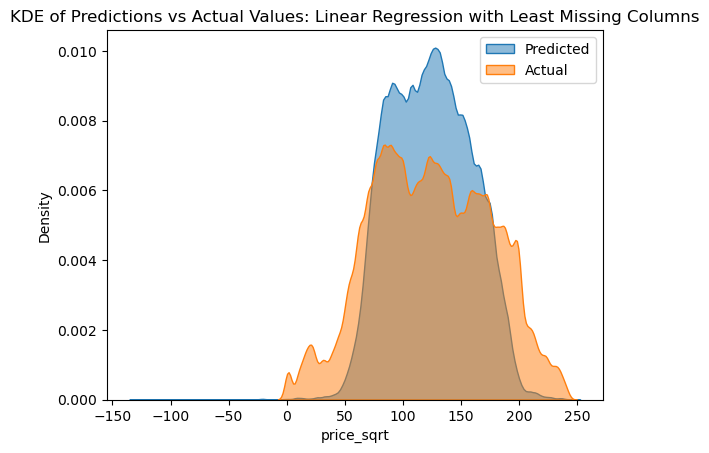

In [242]:
# Update the pipeline to include StandardScaler
preprocessor = make_column_transformer((Pipeline([('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
                                                      ('scaler', StandardScaler())]), least_missing_numeric_cols),
                                           (OneHotEncoder(handle_unknown='ignore'), least_missing_categorical_cols))

pipe = Pipeline([('preprocessor', preprocessor), ('poly_model', LinearRegression())])

pipe.fit(X_train[least_missing_cols], y_train)
feature_names = preprocessor.get_feature_names_out()
predict_val = pipe.predict(X_val[least_missing_cols])
rmse = np.sqrt(mean_squared_error(y_val, predict_val))
print(rmse)

sns.kdeplot(predict_val, label = 'Predicted', fill=True, alpha = 0.5, bw_adjust=0.5)
sns.kdeplot(y_val, label = 'Actual', fill = True, alpha = 0.5, bw_adjust=0.5)

plt.title("KDE of Predictions vs Actual Values: Linear Regression with Least Missing Columns")
plt.legend()
plt.show()

,Coefficients
pipeline__year,120827.78
pipeline__odometer,-1045.74
pipeline__year^2,-245024.28
pipeline__year odometer,2324.12
pipeline__odometer^2,-143.94
pipeline__year^3,124218.57
pipeline__year^2 odometer,-1300.96
pipeline__year odometer^2,204.06
pipeline__odometer^3,-41.17
onehotencoder__fuel_diesel,-98514622023.27


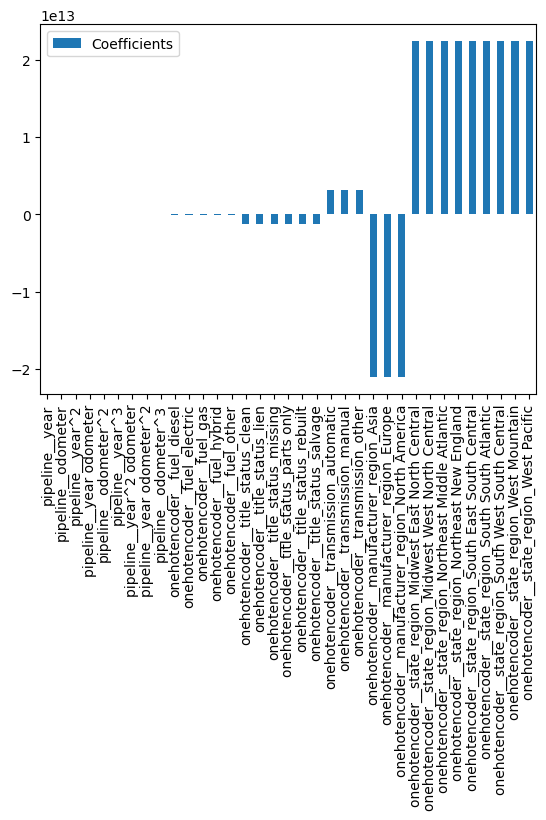

In [243]:
coefficients = pd.DataFrame(pipe.named_steps['poly_model'].coef_, feature_names, columns = ["Coefficients"])
display(coefficients)
coefficients.plot(kind = "bar");

### Ridge Regression

Validation RMSE: 37.35357470568357
Best Alpha: 0.001


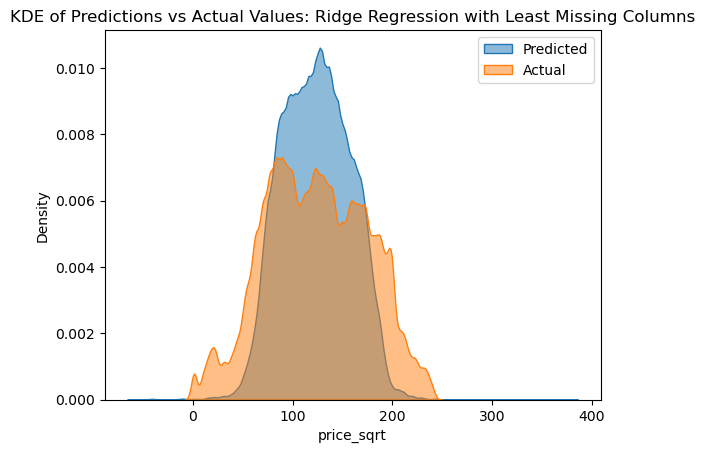

In [245]:
preprocessor = make_column_transformer((Pipeline([('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
                                                      ('scaler', StandardScaler())]), least_missing_numeric_cols),
                                           (OneHotEncoder(handle_unknown='ignore'), least_missing_categorical_cols))

ridge_pipe = Pipeline([('preprocessor', preprocessor), ('ridge_model', Ridge())])

param_dict = {'ridge_model__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}

grid = GridSearchCV(ridge_pipe, param_grid=param_dict)
grid.fit(X_train[least_missing_cols], y_train)
train_preds = grid.predict(X_train[least_missing_cols])
val_preds = grid.predict(X_val[least_missing_cols])
model_train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
model_test_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
model_best_alpha = grid.best_params_


print(f'Validation RMSE: {model_test_rmse}')
print(f'Best Alpha: {list(model_best_alpha.values())[0]}')

sns.kdeplot(val_preds, label = 'Predicted', fill=True, alpha = 0.5, bw_adjust=0.5)
sns.kdeplot(y_val, label = 'Actual', fill = True, alpha = 0.5, bw_adjust=0.5)

plt.title("KDE of Predictions vs Actual Values: Ridge Regression with Least Missing Columns")
plt.legend()
plt.show()

,Coefficients
pipeline__year,15997.33
pipeline__odometer,-2092.78
pipeline__year^2,-34284.11
pipeline__year odometer,4693.01
pipeline__odometer^2,-372.40
pipeline__year^3,18303.54
pipeline__year^2 odometer,-2627.75
pipeline__year odometer^2,449.65
pipeline__odometer^3,-54.38
onehotencoder__fuel_diesel,41.72


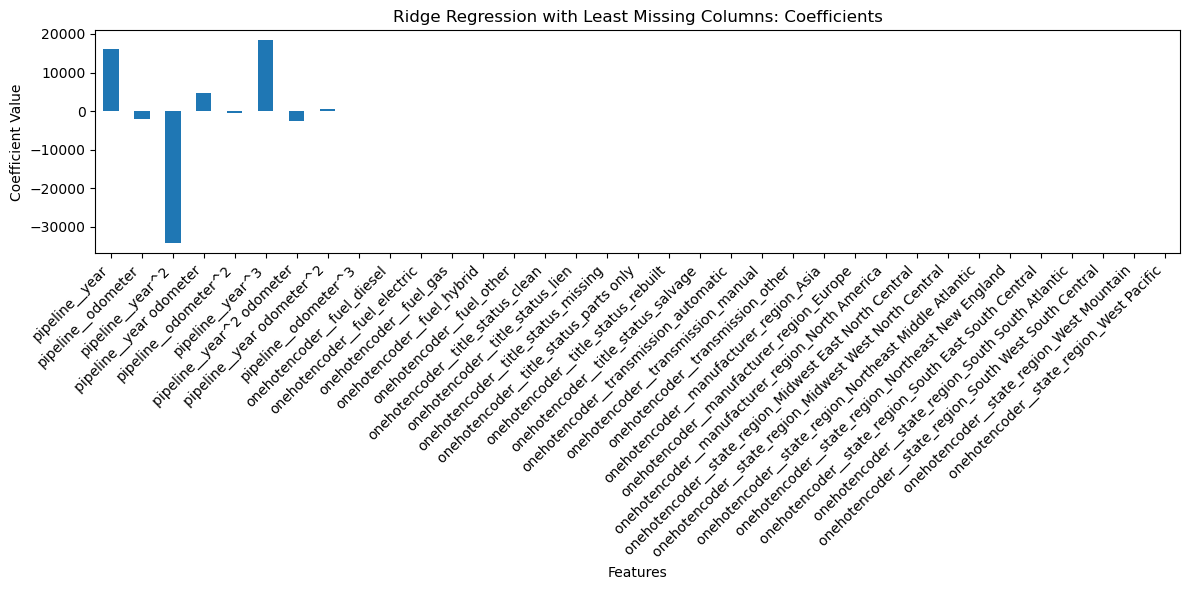

In [246]:
# Extract the best estimator from GridSearchCV
best_model = grid.best_estimator_

# Access the preprocessor step
preprocessor = best_model.named_steps['preprocessor']

# Get feature names from the preprocessor (handles both numeric and categorical)
feature_names = preprocessor.get_feature_names_out()

# Retrieve the coefficients from the Ridge model step
ridge_model = best_model.named_steps['ridge_model']
coefficients = pd.DataFrame(ridge_model.coef_, index=feature_names, columns=["Coefficients"])

# Display the coefficients DataFrame
display(coefficients)

# Plot the coefficients
coefficients.plot(kind="bar", figsize=(12, 6), legend=False)
plt.title("Ridge Regression with Least Missing Columns: Coefficients")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Lasso Regression

Validation RMSE: 39.2225345062024
Best Alpha: 0.001


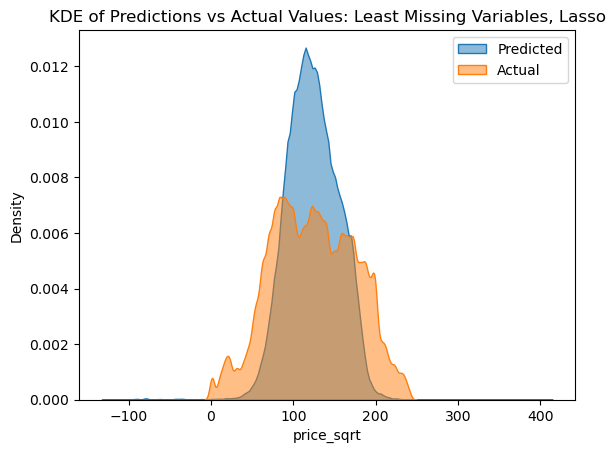

In [248]:
preprocessor = make_column_transformer((Pipeline([('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
                                                      ('scaler', StandardScaler())]), least_missing_numeric_cols),
                                           (OneHotEncoder(handle_unknown='ignore'), least_missing_categorical_cols))

lasso_pipe = Pipeline([('preprocessor', preprocessor), ('lasso_model', Lasso(random_state=21))])

param_dict = {'lasso_model__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}

grid = GridSearchCV(lasso_pipe, param_grid=param_dict)
grid.fit(X_train[least_missing_cols], y_train)
train_preds = grid.predict(X_train[least_missing_cols])
val_preds = grid.predict(X_val[least_missing_cols])
model_train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
model_test_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
model_best_alpha = grid.best_params_


print(f'Validation RMSE: {model_test_rmse}')
print(f'Best Alpha: {list(model_best_alpha.values())[0]}')

sns.kdeplot(val_preds, label = 'Predicted', fill=True, alpha = 0.5, bw_adjust=0.5)
sns.kdeplot(y_val, label = 'Actual', fill = True, alpha = 0.5, bw_adjust=0.5)

plt.title("KDE of Predictions vs Actual Values: Least Missing Variables, Lasso")
plt.legend()
plt.show()

,Coefficients
pipeline__year,-144.05
pipeline__odometer,18.15
pipeline__year^2,76.92
pipeline__year odometer,0.18
pipeline__odometer^2,77.39
pipeline__year^3,80.22
pipeline__year^2 odometer,-68.16
pipeline__year odometer^2,61.15
pipeline__odometer^3,-94.10
onehotencoder__fuel_diesel,51.74


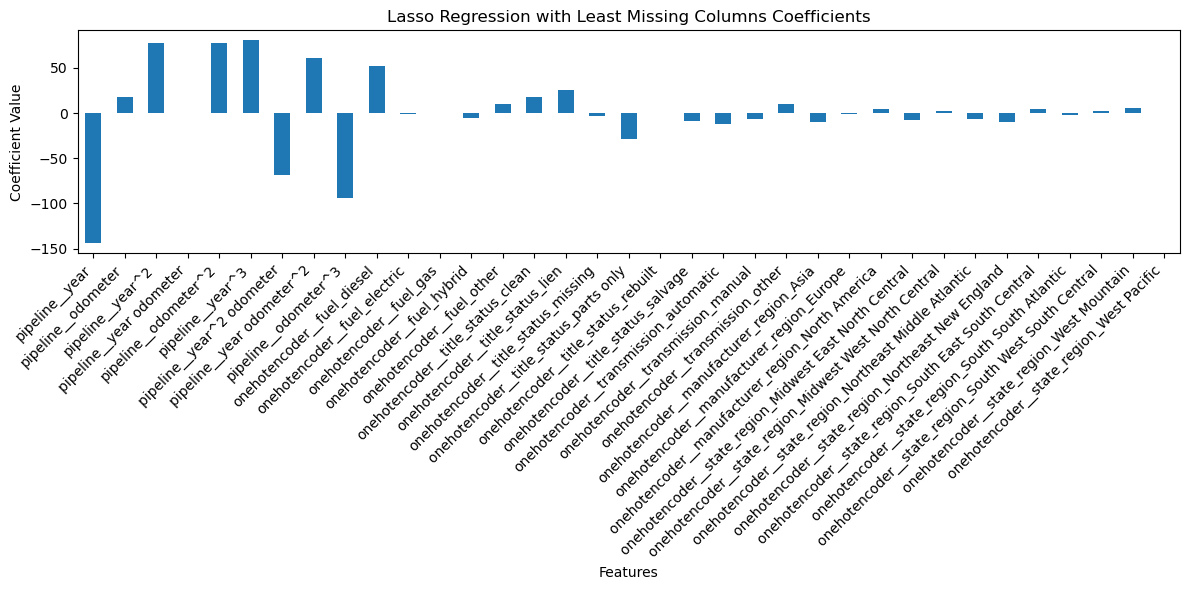

In [249]:
# Extract the best estimator from GridSearchCV
best_model = grid.best_estimator_

# Access the preprocessor step
preprocessor = best_model.named_steps['preprocessor']

# Get feature names from the preprocessor (handles both numeric and categorical)
feature_names = preprocessor.get_feature_names_out()

# Retrieve the coefficients from the Ridge model step
lasso_model = best_model.named_steps['lasso_model']
coefficients = pd.DataFrame(lasso_model.coef_, index=feature_names, columns=["Coefficients"])

# Display the coefficients DataFrame
display(coefficients)

# Plot the coefficients
coefficients.plot(kind="bar", figsize=(12, 6), legend=False)
plt.title("Lasso Regression with Least Missing Columns Coefficients")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## All Numeric and All Categorical Columns:
### Linear Regression

In [251]:
# Reset the transform output to default
set_config(transform_output="default")

for i in range(1, 11):
    # Define preprocessing steps
    preprocessor = make_column_transformer((Pipeline([('poly_features', PolynomialFeatures(degree=i, include_bias=False)),
                                                      ('scaler', StandardScaler())]), numeric_cols),
                                           (OneHotEncoder(handle_unknown='ignore'), categorical_cols))
    pipe = Pipeline([('preprocessor', preprocessor), ('poly_model', LinearRegression())])
    pipe.fit(X_train, y_train)
    predict_val = pipe.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, predict_val))
    poly_model_rmse[f'degree_{i}_rmse'] = rmse

poly_model_rmse

{'degree_1_rmse': 39.294460371645506,
 'degree_2_rmse': 34.34775566272548,
 'degree_3_rmse': 33.04778610364934,
 'degree_4_rmse': 32.93153780527896,
 'degree_5_rmse': 32.77965411738489,
 'degree_6_rmse': 32.679541977681154,
 'degree_7_rmse': 33.322428675621445,
 'degree_8_rmse': 33.56087037133101,
 'degree_9_rmse': 148.30147745964481,
 'degree_10_rmse': 2059.163388644671}

33.04778610364934


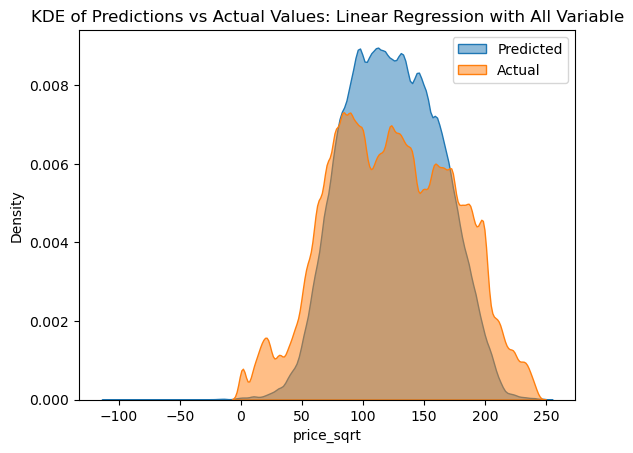

In [252]:
# Update the pipeline to include StandardScaler
preprocessor = make_column_transformer((Pipeline([('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
                                                      ('scaler', StandardScaler())]), numeric_cols),
                                           (OneHotEncoder(handle_unknown='ignore'), categorical_cols))

pipe = Pipeline([('preprocessor', preprocessor), ('poly_model', LinearRegression())])

pipe.fit(X_train, y_train)
feature_names = preprocessor.get_feature_names_out()
predict_val = pipe.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, predict_val))
print(rmse)

sns.kdeplot(predict_val, label = 'Predicted', fill=True, alpha = 0.5, bw_adjust=0.5)
sns.kdeplot(y_val, label = 'Actual', fill = True, alpha = 0.5, bw_adjust=0.5)

plt.title("KDE of Predictions vs Actual Values: Linear Regression with All Variable")
plt.legend()
plt.show()

### Ridge Regression

Validation RMSE: 39.2225345062024
Best Alpha: 0.001


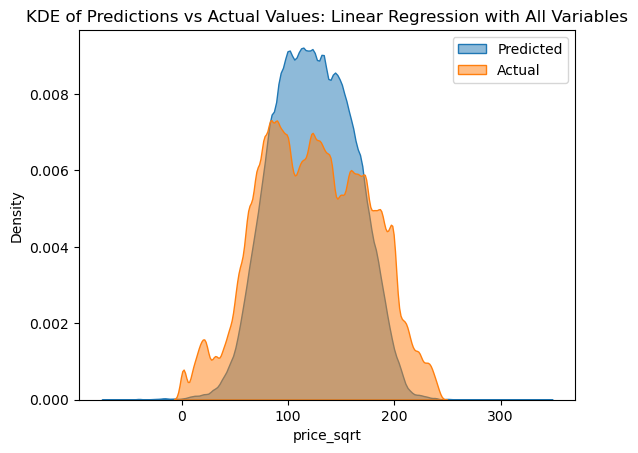

In [254]:
preprocessor = make_column_transformer((Pipeline([('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
                                                      ('scaler', StandardScaler())]), numeric_cols),
                                           (OneHotEncoder(handle_unknown='ignore'), categorical_cols))

ridge_pipe = Pipeline([('preprocessor', preprocessor), ('ridge_model', Ridge())])

param_dict = {'ridge_model__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}

grid = GridSearchCV(ridge_pipe, param_grid=param_dict)
grid.fit(X_train, y_train)
train_preds = grid.predict(X_train)
val_preds = grid.predict(X_val)
model_train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
model_val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
model_best_alpha = grid.best_params_


print(f'Validation RMSE: {model_test_rmse}')
print(f'Best Alpha: {list(model_best_alpha.values())[0]}')

sns.kdeplot(val_preds, label = 'Predicted', fill=True, alpha = 0.5, bw_adjust=0.5)
sns.kdeplot(y_val, label = 'Actual', fill = True, alpha = 0.5, bw_adjust=0.5)

plt.title("KDE of Predictions vs Actual Values: Linear Regression with All Variables")
plt.legend()
plt.show()

,Coefficients
pipeline__year,15576.95
pipeline__odometer,-2152.81
pipeline__condition_ordinal,-2383.41
pipeline__year^2,-33617.81
pipeline__year odometer,4909.66
...,...
onehotencoder__state_region_South East South Central,4.72
onehotencoder__state_region_South South Atlantic,-1.22
onehotencoder__state_region_South West South Central,2.01
onehotencoder__state_region_West Mountain,5.73


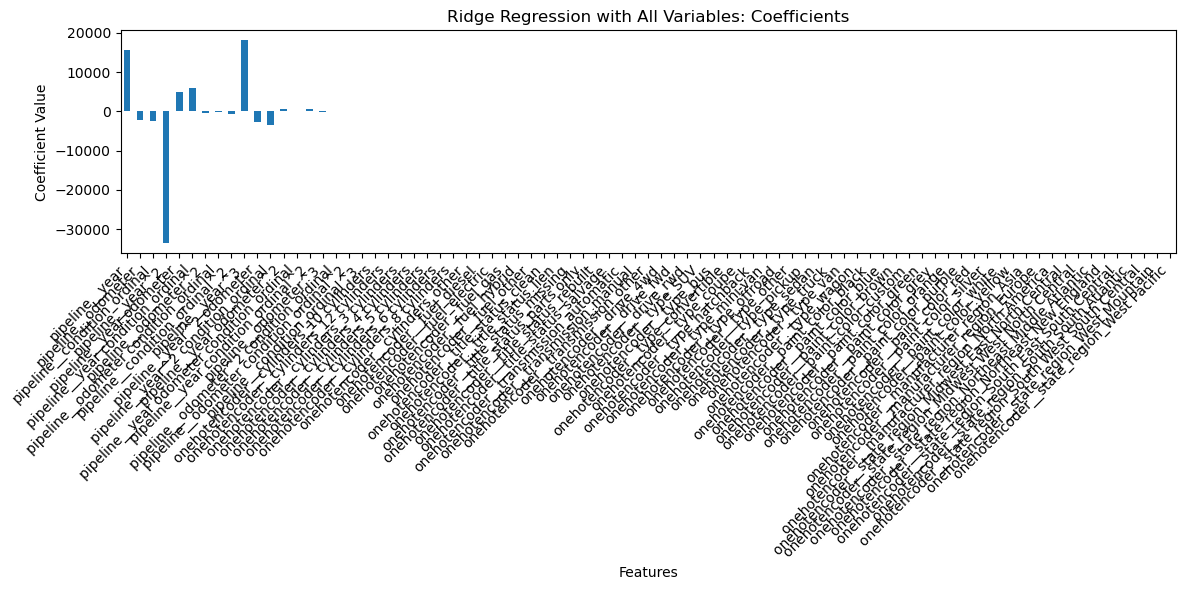

In [255]:
# Extract the best estimator from GridSearchCV
best_model = grid.best_estimator_

# Access the preprocessor step
preprocessor = best_model.named_steps['preprocessor']

# Get feature names from the preprocessor (handles both numeric and categorical)
feature_names = preprocessor.get_feature_names_out()

# Retrieve the coefficients from the Ridge model step
ridge_model = best_model.named_steps['ridge_model']
coefficients = pd.DataFrame(ridge_model.coef_, index=feature_names, columns=["Coefficients"])

# Display the coefficients DataFrame
display(coefficients)

# Plot the coefficients
coefficients.plot(kind="bar", figsize=(12, 6), legend=False)
plt.title("Ridge Regression with All Variables: Coefficients")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Lasso Regression

Validation RMSE: 35.98004583871175
Best Alpha: 0.001


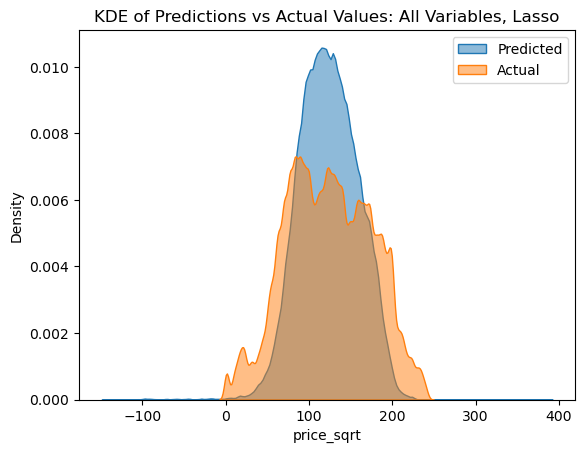

In [257]:
preprocessor = make_column_transformer((Pipeline([('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
                                                      ('scaler', StandardScaler())]), numeric_cols),
                                           (OneHotEncoder(handle_unknown='ignore'), categorical_cols))

lasso_pipe = Pipeline([('preprocessor', preprocessor), ('lasso_model', Lasso(random_state=21))])

param_dict = {'lasso_model__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}

grid = GridSearchCV(lasso_pipe, param_grid=param_dict)
grid.fit(X_train, y_train)
train_preds = grid.predict(X_train)
val_preds = grid.predict(X_val)
model_train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
model_val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
model_best_alpha = grid.best_params_


print(f'Validation RMSE: {model_val_rmse}')
print(f'Best Alpha: {list(model_best_alpha.values())[0]}')

sns.kdeplot(val_preds, label = 'Predicted', fill=True, alpha = 0.5, bw_adjust=0.5)
sns.kdeplot(y_val, label = 'Actual', fill = True, alpha = 0.5, bw_adjust=0.5)

plt.title("KDE of Predictions vs Actual Values: All Variables, Lasso")
plt.legend()
plt.show()

,Coefficients
pipeline__year,-141.49
pipeline__odometer,15.57
pipeline__condition_ordinal,30.36
pipeline__year^2,77.36
pipeline__year odometer,-0.78
...,...
onehotencoder__state_region_South East South Central,4.80
onehotencoder__state_region_South South Atlantic,-2.61
onehotencoder__state_region_South West South Central,2.39
onehotencoder__state_region_West Mountain,4.95


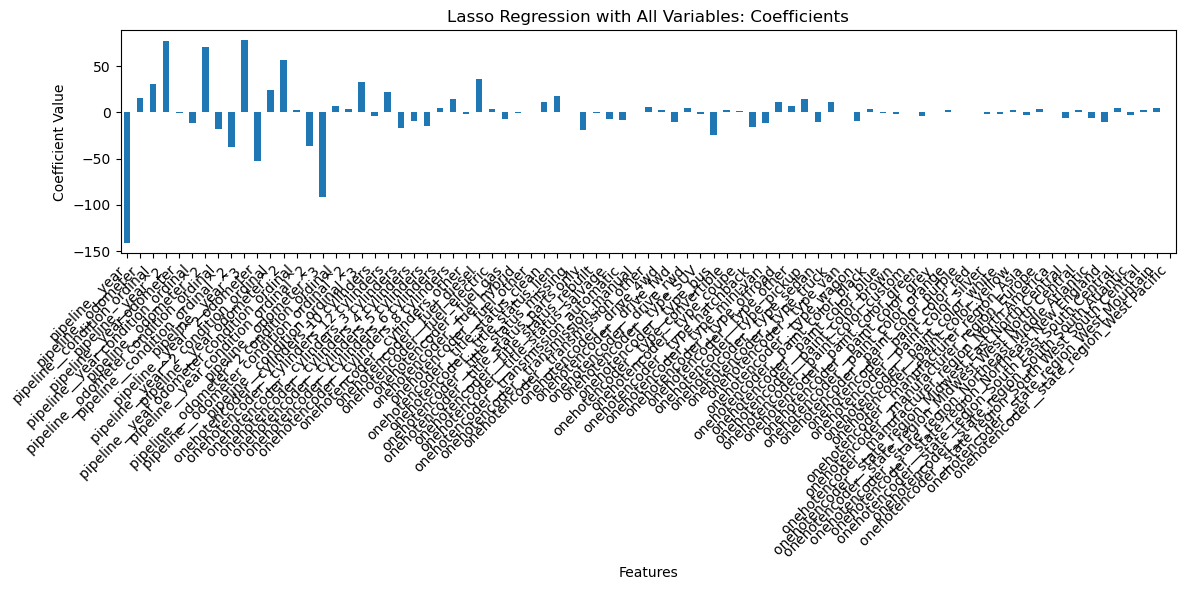

In [258]:
# Extract the best estimator from GridSearchCV
best_model = grid.best_estimator_

# Access the preprocessor step
preprocessor = best_model.named_steps['preprocessor']

# Get feature names from the preprocessor (handles both numeric and categorical)
feature_names = preprocessor.get_feature_names_out()

# Retrieve the coefficients from the Ridge model step
lasso_model = best_model.named_steps['lasso_model']
coefficients = pd.DataFrame(lasso_model.coef_, index=feature_names, columns=["Coefficients"])

# Display the coefficients DataFrame
display(coefficients)

# Plot the coefficients
coefficients.plot(kind="bar", figsize=(12, 6), legend=False)
plt.title("Lasso Regression with All Variables: Coefficients")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Best Model

In [402]:
# Update the pipeline to include StandardScaler
preprocessor = make_column_transformer((Pipeline([('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
                                                      ('scaler', StandardScaler())]), numeric_cols),
                                           (OneHotEncoder(handle_unknown='ignore'), categorical_cols))

pipe = Pipeline([('preprocessor', preprocessor), ('poly_model', LinearRegression())])

pipe.fit(X_train, y_train)
feature_names = preprocessor.get_feature_names_out()
predict_test = pipe.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_test, predict_test))
print(rmse)

r2 = pipe.score(X_test, y_test)

print(r2)

63.67410314251574
0.5670815942953822


# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

**From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.**

---

The primary objective of this analysis is to develop a predictive model for determining the prices of used vehicles based on various features. This analysis is intended to support a used car dealership in pricing vehicles accurately and competitively. By understanding the factors that influence vehicle prices, the dealership can enhance its decision-making processes for purchasing inventory, setting resale prices, and targeting specific customer demographics.

Key Questions to Address:

1.	What are the primary drivers of used vehicle prices?
	*	We aim to identify which factors (e.g., year, odometer reading, type, region, etc.) most significantly influence the price of a used vehicle.
2.	How can the dealership use these insights to maximize profits?
	*	By understanding which attributes add the most value, the dealership can strategically source vehicles with desirable features (e.g., lower mileage, popular models, or specific types such as SUVs or pickups).
3.	Are there specific customer preferences based on region or type?
	*	Insights into regional or demographic preferences can help tailor inventory to the local market.

Project Scope:

* The dataset includes 426,880 entries with various features such as vehicle specifications, condition, and region.
* The response variable is vehicle price, which exhibits strong right skewness due to extreme outliers.
* The analysis focuses on understanding the relationship between price and explanatory variables, including numerical attributes (e.g., odometer and year) and categorical features (e.g., fuel type, transmission).

Business Impact:

This analysis supports operational efficiency and customer satisfaction:
* Optimized Pricing: Ensures competitive pricing strategies while maximizing profitability.
* Inventory Management: Guides procurement by identifying high-demand vehicle attributes.
* Customer Targeting: Helps design marketing campaigns that emphasize features most valued by buyers in different regions.

Constraints and Challenges:

* Data Quality: Handling missing data for key variables (e.g., condition, cylinders) is critical to maintaining model accuracy.
* Outliers: Extreme values (e.g., unusually high-priced vehicles) can distort the analysis, necessitating transformations or removal methods.
* Interpretability: Ensuring the model remains interpretable for business stakeholders, even when using advanced regression techniques.

### Data Understanding

**After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.**

---

The dataset for this project contains information about **426,880 used vehicles**. The primary goal is to leverage this data to understand the factors influencing vehicle prices and to develop a predictive model. The key steps involved in understanding the data include summarizing its structure, identifying potential issues, and examining the relationships between variables.


Dataset Overview:

* Size: 426,880 rows and 17 columns.
* Response Variable: price (numeric), representing the selling price of each vehicle.
* Explanatory Variables:
    * Numerical Variables:
	* year: The manufacturing year of the vehicle.
	* odometer: The mileage on the vehicle.
* Categorical Variables (examples):
	* manufacturer, model, fuel, transmission, drive, paint_color, state, type, etc.

Initial Observations:

1.	Data Types:
* 3 numerical variables: price (target), year, and odometer.
* 14 categorical variables.
* The VIN column was excluded as it does not contribute to pricing.
2.	Missing Data:
* Several variables, such as condition, cylinders, drive, and paint_color, have significant missing values (>30%).
* Features with lower percentages of missing data (e.g., year, fuel, title_status) are good candidates for imputation.
3.	Outliers:
* Vehicle prices range from $1 to over $3.7 billion, indicating extreme outliers.
* Transformations (e.g., log or square root) and outlier removal techniques (z-score or IQR method) were explored to handle skewness and improve model performance.

Exploratory Data Analysis Highlights:

1.	Univariate Analysis:
	* Target Variable (price):
	* Skewed distribution due to high-priced vehicles.
	* Median price around 15,000 dollars -  75 percent of prices below $27,590.
	* Numerical Variables:
    	* year is positively correlated with price (newer cars sell for more).
    	* odometer is negatively correlated with price (lower mileage increases value).
	* Categorical Variables:
    	* Features like fuel, drive, type, and paint_color show distinct pricing patterns.
2.	Bivariate Analysis:
	* Correlation:
    	* Stronger correlations observed after transforming price (e.g., with square root transformation).
    	* Positive correlation between year and price; negative correlation between odometer and price.
	* Categorical Variables:
    	* Certain categories, like 4wd in drive or electric in fuel, are associated with higher prices.

Data Cleaning Steps:

1.	Dropped Variables:
	* VIN: Unique identifier with no relevance to price.
	* region, model: High cardinality made them impractical for one-hot encoding.
	* condition, size: High percentage of missing values (>40% and >70%, respectively).
2.	Imputation:
	* Features with missing data (e.g., fuel, transmission) were imputed with mode or median.
3.	Feature Engineering:
	* Created ordinal variables for condition and size.
	* Mapped high-cardinality variables (manufacturer, state) into broader categories (e.g., regions).

Key Insights from Data Exploration:

* Year and odometer are critical predictors, with clear linear relationships to price.
* Categorical variables like type, fuel, and manufacturer_region provide significant explanatory power, as seen in violin plots and group statistics.
* Missing and outlier handling significantly improves the dataset’s usability and prepares it for regression modeling.

### Data Preparation

**After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.**

---

The data preparation phase involved cleaning, transforming, and organizing the dataset to ensure suitability for predictive modeling. This step addressed missing values, outliers, and variable encoding to optimize model performance.

1. Handling Missing Data

	1.	Columns with Low Missing Rates (<5%):
	* Imputed with the mode or mean:
	* Categorical Variables: fuel, transmission, title_status.
	* Numerical Variables: year, odometer.
	2.	Columns with High Missing Rates (>30%):
	* Excluded at first from analysis, then brought back in at the end to increase signal:
    	* condition (40.8%), cylinders (41.6%), drive (30.6%), paint_color (30.5%), and size (71.8%).
	3.	Final Strategy:
	* Retained columns with enough usable data to avoid over-reduction.
	* Imputed where appropriate to preserve key features for modeling.

2. Outlier Treatment

	1.	Outliers in price:
	* Detected extreme outliers using box plots and summary statistics.
	* Applied two methods for outlier handling:
	* Z-Score Method: Removed values with z-scores > 3, losing ~0.5% of data.
	* IQR Method: Removed values outside 1.5 times the interquartile range (IQR), losing ~2% of data.
	* Chose the IQR Method, as it removed extreme values effectively without distorting the dataset.
	2.	Log and Square Root Transformations:
	* Transformed the response variable (price) to normalize its distribution:
	* price_log: Log transformation.
	* price_sqrt: Square root transformation (chosen for final analysis due to its better normalization).

3. Feature Engineering

	1.	Variable Transformation:
	* Created ordinal variables for condition and size.
	* Recoded high-cardinality variables (manufacturer, state) into aggregated groups:
	* Manufacturer Region: Grouped into North America, Asia, and Europe.
	* State Region: Mapped into nine census-based regions.
	2.	Feature Selection:
	* Retained variables:
	* Numerical: year, odometer.
	* Categorical: fuel, transmission, title_status, type, manufacturer_region, and state_region.
	* Dropped high-cardinality or irrelevant variables:
    	* VIN, region, model.

4. Data Splitting

	1.	Train/Validation/Test Split:
	* Split data into 70% training, 15% validation, and 15% test sets.
	* Ensured balanced distribution of price across splits.
	2.	Final Dataset:
	* Response Variable: price_sqrt.
	* Predictor Variables: A mix of transformed numerical and encoded categorical features.

5. Encoding Categorical Variables

	* Applied one-hot encoding for nominal variables like fuel and type.
	* Used ordinal encoding for variables with intrinsic order, such as condition_ordinal.

Key Adjustments
* Chose to optimize interpretability and predictive power by carefully balancing variable selection, imputation, and transformation.
* Addressed potential multicollinearity by dropping redundant variables (e.g., manufacturer when manufacturer_region was used).

### Modeling

**With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.**

---

1. Model Selection

Linear regression was chosen as the primary modeling approach due to:
* Its simplicity and interpretability for understanding the relationships between predictors and the response variable.
* The numerical nature of the target variable (price_sqrt).

Several variations of linear regression were explored

* Multiple Linear Regression
   * Baseline model using all preprocessed features.
* Ridge Regression:
    * Regularized model to address potential overfitting and multicollinearity.
* Lasso Regression:
    * Regularized model for feature selection, reducing less significant predictors.

2. Training and Validation

	1.	Train/Validation Split:
	* The dataset was divided into 70% training and 15% validation sets to tune model hyperparameters.
	* The remaining 15% was reserved for final testing.
	2.	Feature Engineering:
	* Predictor Variables:
	* Numerical: year, odometer.
	* Encoded categorical: fuel, type, manufacturer_region, state_region, etc.
	* Response Variable:
    	* price_sqrt, selected for its normality and reduced skewness.
	3.	Pipeline Implementation:
	* Standardized numerical predictors using StandardScaler.
	* Applied one-hot encoding to categorical variables using ColumnTransformer.
	* Integrated preprocessing into a pipeline for efficient model building and evaluation.

3. Hyperparameter Tuning

	1.	Ridge Regression:
	* Tuning parameter: Regularization strength (alpha).
	* Explored a grid of values (e.g., alpha = 0.1, 1, 10, 100).
	* Selected the model minimizing validation set error.
	2.	Lasso Regression:
	* Tuning parameter: Regularization strength (alpha).
	* Used a similar grid search approach as Ridge Regression.
	3.	Evaluation Metric:
	* Root Mean Squared Error (RMSE) on the validation set was used to compare models and tune hyperparameters.

4. Final Model

The best-performing model was the multiple linear regression model using all cleaned and imputed variables. Key reasons:
* Performance: Provided the lowest MSE compared to Ridge and Lasso regression.
* Interpretability: Clear understanding of the impact of each predictor on the response variable.
* Feature Retention: Unlike Lasso, it retained all variables, providing a comprehensive overview of price drivers.

5. Model Results

	* Validation Performance:
	* RMSE: 63.67410314251574.
	* R²: 0.5670815942953822 (proportion of variance explained by the model).
	* Key Predictors:
    	* year: Positive correlation with price.
    	* odometer: Negative correlation with price.
    	* fuel and type: Significant categorical predictors.
    	* manufacturer_region: Notable regional differences in price.

6. Limitations

	* Linear regression assumes a linear relationship, which may not capture complex interactions.
	* Despite handling outliers and transformations, some predictors (e.g., fuel, type) showed non-linear effects.

### Evaluation

**With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.**

---

1. Model Performance

The final model’s performance was evaluated using the test dataset, which represented 15% of the total data and was held out during training and validation.

Key Metrics:
* Root Mean Squared Error (RMSE): 63.67410314251574, a more interpretable measure of average prediction error in the original price unit.
* R² Score: 0.5670815942953822, showing the proportion of variance in vehicle prices explained by the model.

Interpretation:
* The model demonstrated strong predictive accuracy, capturing the primary drivers of vehicle prices while generalizing well to unseen data.
* The R² score indicates that a significant portion of the variability in used vehicle prices is explained by the predictors, validating the choice of features and transformations.

It should be noted that compared to our test R Squared of the dummy regression, we are seeing a dramatic improvement from roughly -0.00002 to 0.57. This model can explain a lot of the variance, but it looks like there are still some cases where we do not perform well on the predictions. This is why our dummy RMSE is relatively decent. We also could have some overfitting in our model. If I had more time, or if our goal was to create the best predictor I would use sequential feature selection to trim the variables in our final model. It is possible that our lasso model performs better on the test set, since it shrinks a couple of the coefficients.

2. Insights from the Model

	1.	Key Drivers of Price:
	* Year: Newer vehicles tend to command higher prices.
	* Odometer: Lower mileage is associated with increased vehicle value.
	* Fuel Type: Diesel and electric vehicles tend to be priced higher than gas or hybrid models.
	* Vehicle Type: Pickups and SUVs are among the most valuable categories, while sedans and mini-vans are generally lower-priced.
	* Manufacturer Region: Vehicles from Europe and North America are priced higher than those from Asia on average.
	2.	Business Implications:
	* The dealership can prioritize acquiring vehicles with attributes that yield higher prices (e.g., newer vehicles, diesel or electric fuel types).
	* Targeting specific regional preferences (e.g., SUVs in colder climates) can help align inventory with local demand.

3. Model Limitations

	1.	Assumptions of Linearity:
	* The linear regression model assumes linear relationships between predictors and the response variable. Non-linear effects may not be fully captured.
	* For instance, interactions between fuel and type or non-linear trends in odometer may influence price in ways the model doesn’t account for.
	2.	Imputation of Missing Data:
	* Imputing missing values (e.g., mode for categorical features) might introduce bias, particularly in variables with high missingness (e.g., paint_color).
	3.	Outlier Treatment:
	* While the IQR method removed extreme outliers, some influential but valid observations (e.g., rare luxury cars) may have been excluded, slightly limiting the model’s scope.
	4.	Skewed Distributions:
	* Despite transforming the response variable, predictors like fuel and type exhibit skewed distributions, potentially affecting predictions for underrepresented categories.

4. Areas for Improvement

	1.	Incorporating Non-Linear Models:
	* Exploring advanced techniques like decision trees or ensemble methods (e.g., random forests, gradient boosting) to capture non-linear relationships and interactions.
	2.	Feature Engineering:
	* Creating interaction terms (e.g., year * type) to capture specific market trends.
	* Using external data (e.g., fuel prices, regional economic indicators) for enriched predictions.
	3.	Evaluation Metrics:
	* Supplementing RMSE and R² with business-focused metrics, such as profit margins or percentage deviation from actual prices.

5. Final Takeaways

	* The model meets its primary objective of predicting used vehicle prices with reasonable accuracy.
	* The insights gained provide actionable strategies for pricing, inventory management, and marketing.
	* With further refinement, the dealership can enhance its competitive edge and better meet customer expectations.

### Deployment

**Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.**

1. Deployment Strategy

	1.	Integration into Business Workflow:
	*	The model will be deployed as a web-based tool or API, allowing dealership staff to input vehicle attributes and instantly receive price predictions.
	*	Predictions can assist in:
	*	Pricing vehicles for resale.
	*	Determining trade-in values.
	*	Identifying high-value vehicles for acquisition.
	2.	Technology Stack:
	*	Model Hosting: Use platforms like AWS, Google Cloud, or Azure to host the model for scalability.
	*	User Interface: Develop a simple and intuitive interface using frameworks like Flask, Django, or Shiny (in R).
	*	Database Integration: Connect the system to the dealership’s existing inventory database for seamless data input and storage.
	3.	Access Points:
	*	Desktop and mobile access for dealership staff.
	*	Option to integrate with the dealership’s CRM or inventory management system.

2. Model Deployment Workflow

	1.	Data Pipeline:
	*	Automate data collection from the dealership’s systems (e.g., vehicle specifications and past sales records).
	*	Apply the same preprocessing steps used in model development to ensure consistency.
	2.	Prediction Pipeline:
	*	Input new vehicle data (e.g., year, odometer, type, fuel type) into the deployed model.
	*	Return the predicted price (price_sqrt) and provide both the transformed and actual price for interpretability.
	3.	Reporting and Visualization:
	*	Generate dashboards to display predicted vs. actual prices, sales trends, and inventory insights.
	*	Visualize price distributions across different vehicle attributes to support strategic decisions.

3. Monitoring and Maintenance

	1.	Model Monitoring:
	*	Track model performance using metrics like MSE and RMSE on recent sales data.
	*	Periodically retrain the model with new data to account for market changes (e.g., evolving customer preferences, economic conditions).
	2.	Error Analysis:
	*	Identify instances where the model’s predictions deviate significantly from actual prices.
	*	Investigate patterns in underperforming predictions to refine preprocessing or modeling steps.
	3.	System Updates:
	*	Update features and retrain the model when significant changes occur (e.g., introduction of new fuel types or vehicle categories).
	*	Ensure compatibility with updated dealership systems or third-party integrations.

4. Business Benefits

	1.	Operational Efficiency:
	*	Streamlines the pricing process, reducing manual effort and improving accuracy.
	*	Enhances inventory management by identifying undervalued or overvalued vehicles.
	2.	Customer Satisfaction:
	*	Transparent and competitive pricing builds customer trust and loyalty.
	*	Personalized pricing strategies can attract target customer segments.
	3.	Profit Maximization:
	*	Insights into high-value features and trends enable the dealership to source vehicles strategically.
	*	Minimized pricing errors reduce revenue losses and improve profit margins.

5. Long-Term Considerations

	1.	Scalability:
	*	Design the system to handle increased traffic as the dealership grows or expands its operations.
	*	Ensure the infrastructure supports future enhancements, such as predictive maintenance or market trend forecasting.
	2.	Data Security:
	*	Protect sensitive customer and inventory data through robust encryption and access controls.
	*	Comply with data privacy regulations (e.g., GDPR, CCPA).
	3.	Stakeholder Training:
	*	Train staff on using the system effectively and interpreting model outputs.
	*	Provide documentation and support for troubleshooting common issues.